C:\Users\ved\Desktop\completion-meter\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\ved\Desktop\completion-meter\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
C:\Users\ved\Desktop\completion-meter\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\ved\Desktop\completion-meter\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Clustering complete.


C:\Users\ved\AppData\Local\Temp\ipykernel_13100\2945594133.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab20", n_clusters + 1)


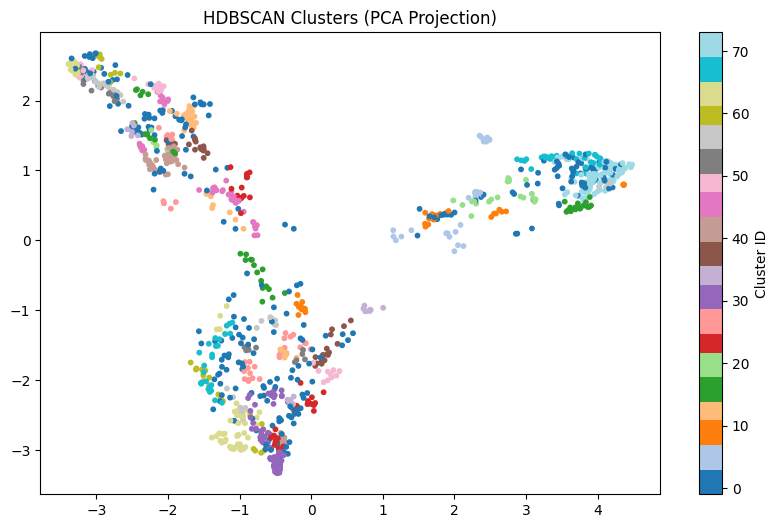

In [8]:
import pandas as pd
import numpy as np
import hdbscan
import ast
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.decomposition import PCA
import umap

df = pd.read_csv("../intermediate_data/embeddings_added.csv")
df["embedding"] = df["embedding"].apply(ast.literal_eval)
embeddings = np.vstack(df["embedding"].values)

pca = PCA(n_components=0.95, svd_solver="full", random_state=42)
pca_embeddings = pca.fit_transform(embeddings)
umap_embeddings = umap.UMAP(n_components=20, random_state=42).fit_transform(pca_embeddings)

clusterer = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=3, metric="euclidean")
labels = clusterer.fit_predict(umap_embeddings)
df["cluster"] = labels 

df.to_csv("../intermediate_data/clustered_embeddings.csv", index=False)
print("Clustering complete.")

pca_vis = PCA(n_components=2).fit_transform(umap_embeddings)
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
cmap = cm.get_cmap("tab20", n_clusters + 1)

plt.figure(figsize=(10,6))
plt.scatter(pca_vis[:,0], pca_vis[:, 1], c=labels, cmap=cmap, s=10)
plt.title("HDBSCAN Clusters (PCA Projection)")
plt.colorbar(label="Cluster ID")
plt.show()

In [4]:
from collections import Counter
print(Counter(labels))

Counter({np.int64(-1): 238, np.int64(72): 47, np.int64(62): 44, np.int64(73): 31, np.int64(11): 30, np.int64(31): 30, np.int64(40): 27, np.int64(71): 27, np.int64(15): 20, np.int64(58): 19, np.int64(29): 19, np.int64(69): 18, np.int64(46): 18, np.int64(1): 18, np.int64(68): 17, np.int64(36): 17, np.int64(48): 16, np.int64(49): 16, np.int64(16): 15, np.int64(7): 15, np.int64(23): 14, np.int64(66): 14, np.int64(60): 13, np.int64(67): 13, np.int64(3): 12, np.int64(25): 12, np.int64(28): 12, np.int64(24): 12, np.int64(42): 12, np.int64(54): 12, np.int64(0): 12, np.int64(22): 11, np.int64(55): 11, np.int64(59): 11, np.int64(32): 11, np.int64(21): 10, np.int64(13): 10, np.int64(53): 10, np.int64(41): 10, np.int64(2): 10, np.int64(10): 10, np.int64(50): 10, np.int64(37): 9, np.int64(63): 9, np.int64(45): 9, np.int64(43): 9, np.int64(70): 8, np.int64(26): 8, np.int64(56): 8, np.int64(57): 8, np.int64(61): 8, np.int64(47): 8, np.int64(44): 8, np.int64(35): 8, np.int64(5): 8, np.int64(4): 8, np.

In [5]:
for cluster_id in sorted(set(labels)):
    if cluster_id == -1:
        print(f"\n[Noise]")
    else:
        print(f"\n[Cluster {cluster_id}]")
    sample_texts = df[df["cluster"] == cluster_id]["text"].head(5).tolist()
    for t in sample_texts:
        print("•", t[:120].replace("\n", " ") + "...")



[Noise]
• agree by agree i mean if he is zero he is zero that is one this is one right which means they both are equivalent right ...
• yes they are okay whenever two columns are precisely the same their corresponding boolean expressions are equivalent wha...
• lets consider another example i would like to look at this boolean expression p and not q or not p and q so what all sho...
• you see what we have seen so far closely observe that we saw different operators like and or xor and things like that ri...
• its not true just the way we did before this is not true this is something else this will be p and q or p and r okay the...

[Cluster 0]
• i will give a good example for this lets say you have a cultural evening at your college and you want your dad or mom on...
• i have a request to raise there is a cultural evening in my college i want dad either you to come or mom you to come one...
• it sounds something like you have only one entry pass and you want dad to come or mom to come 

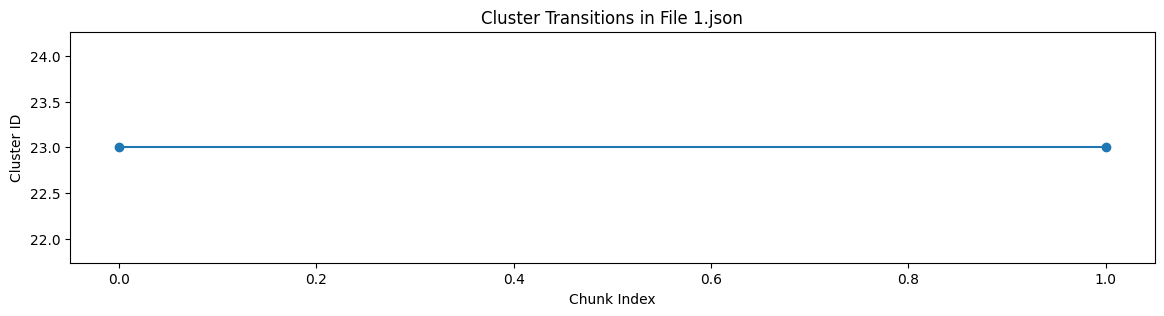

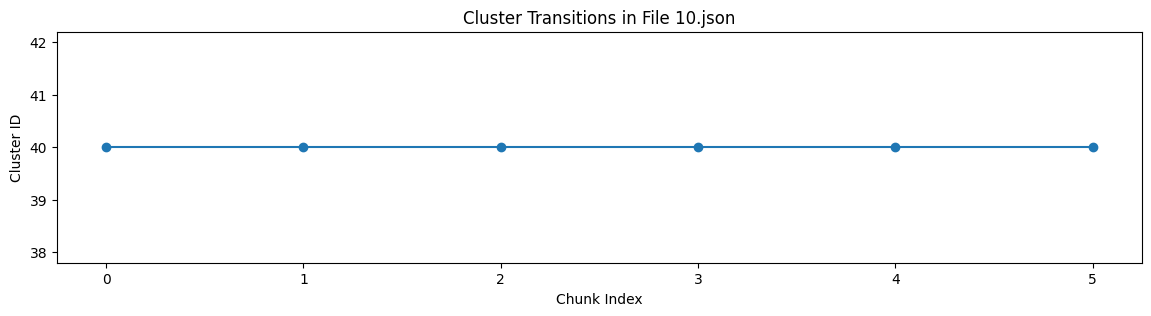

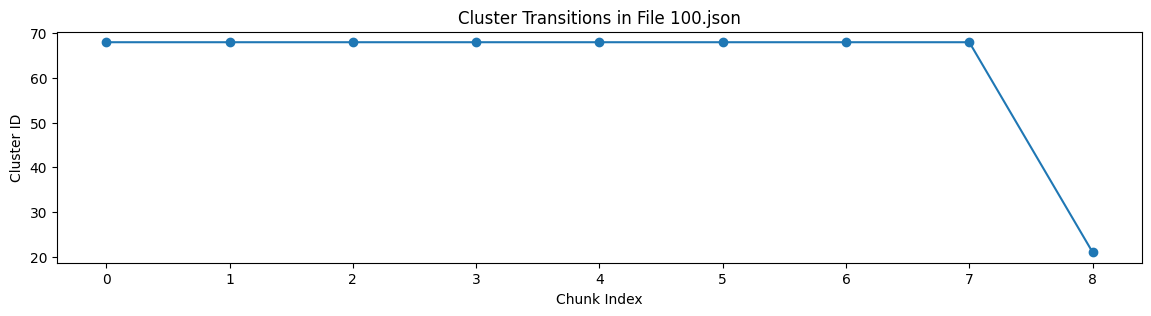

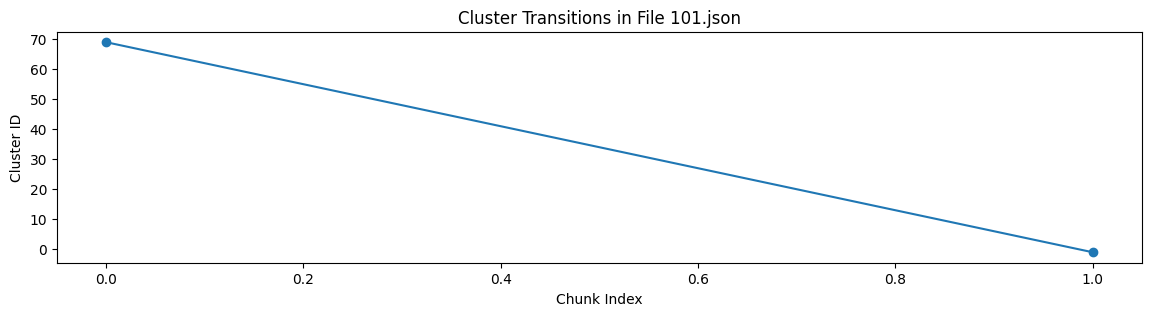

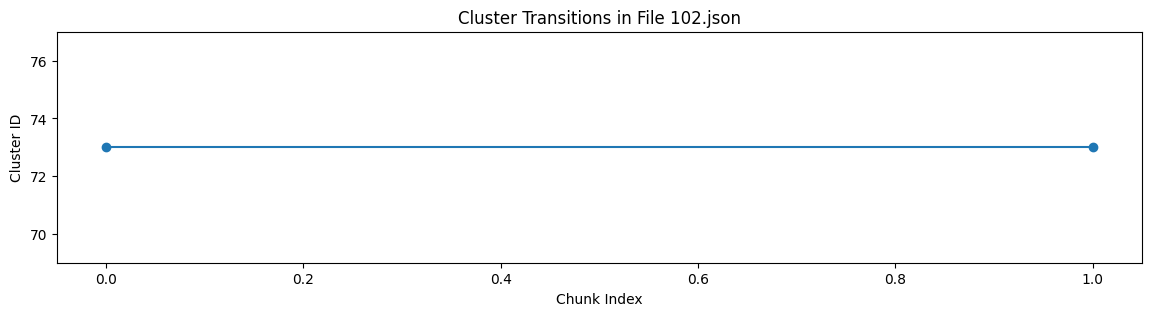

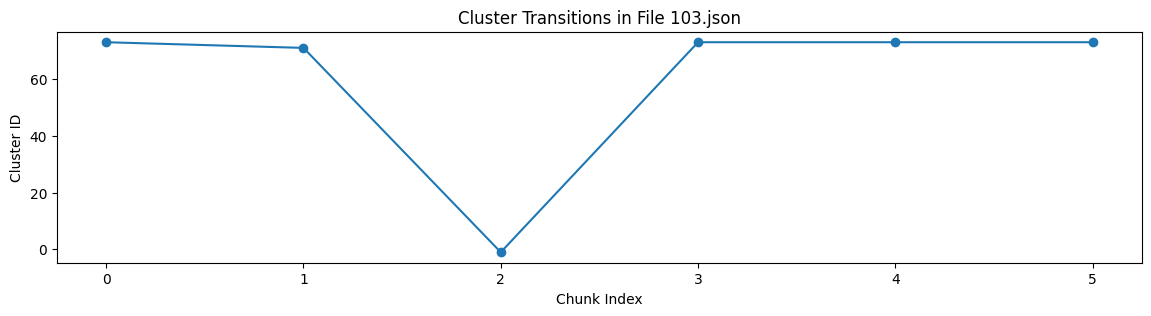

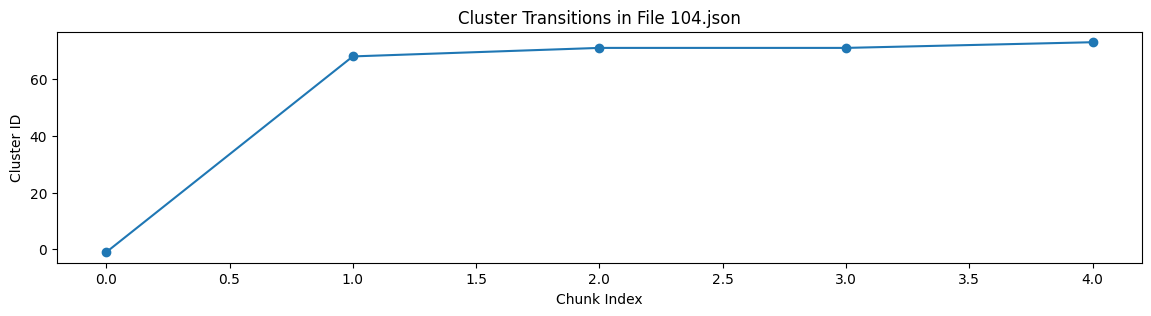

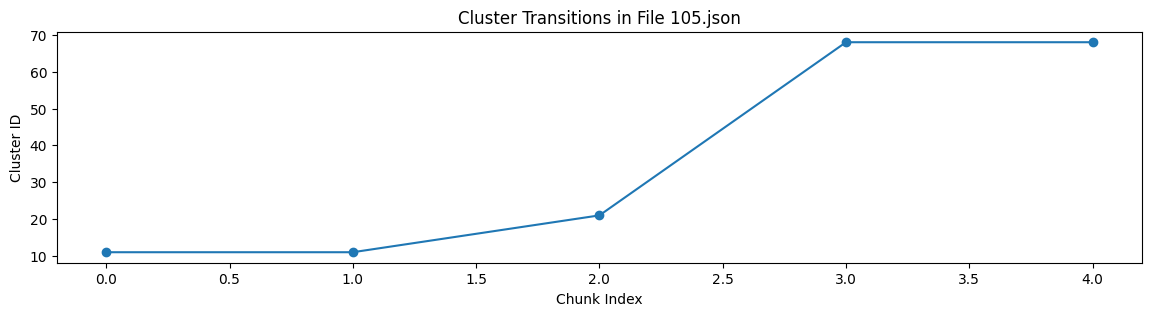

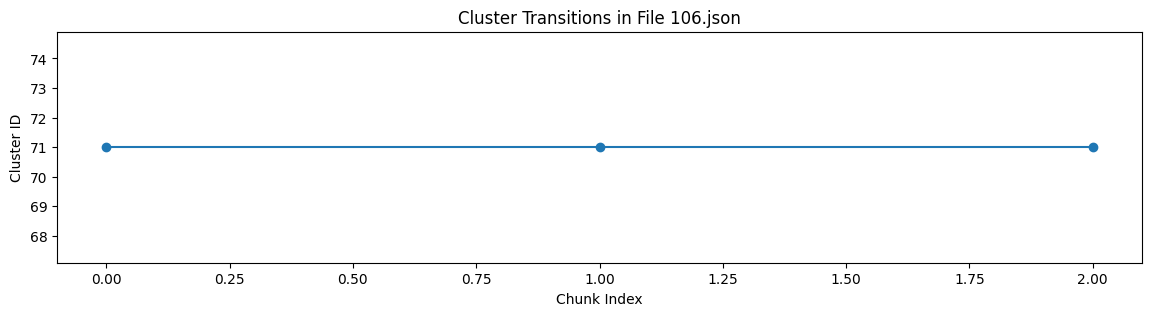

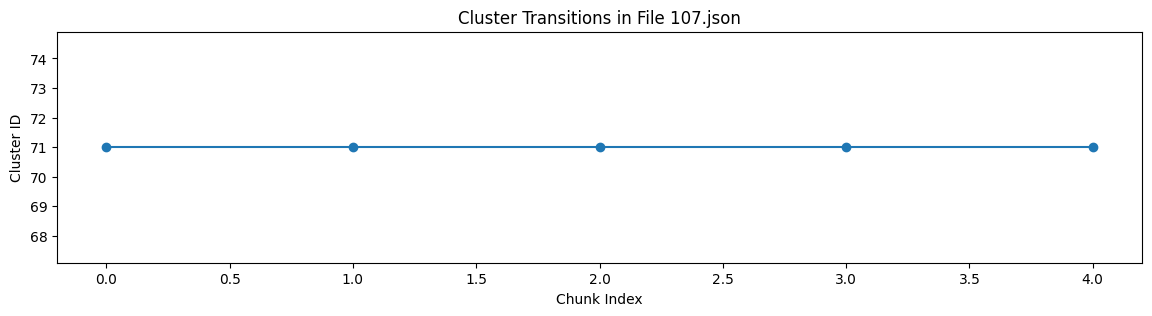

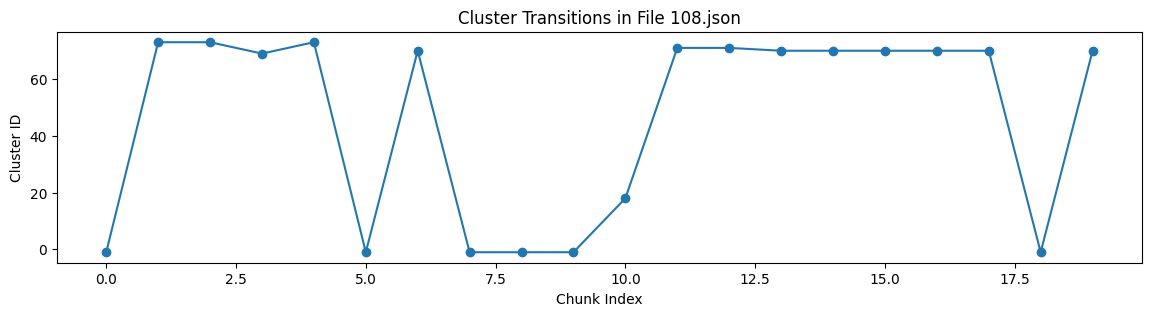

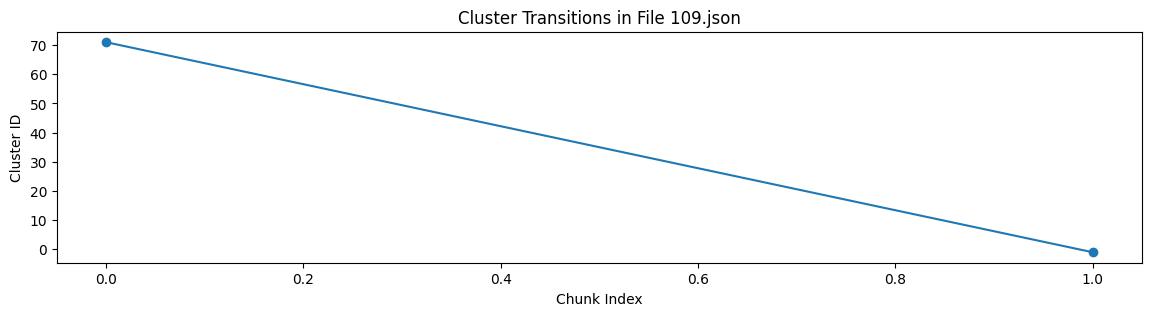

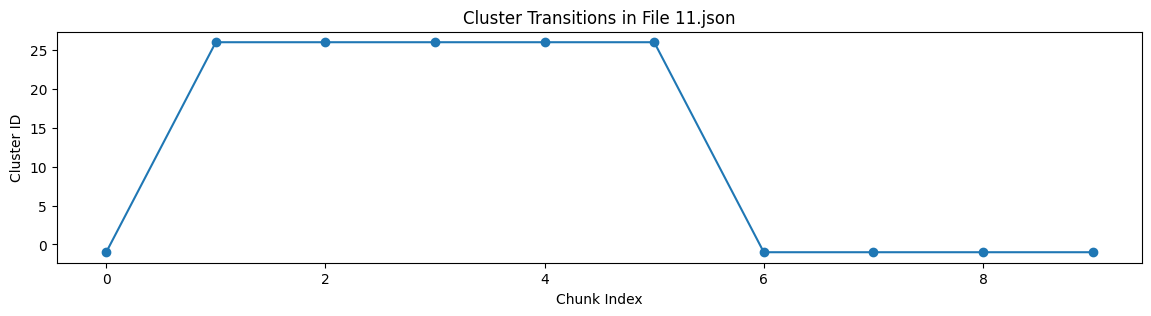

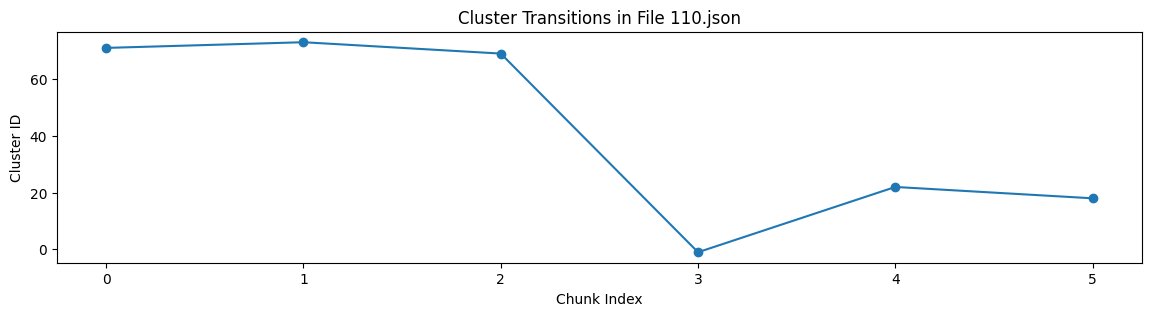

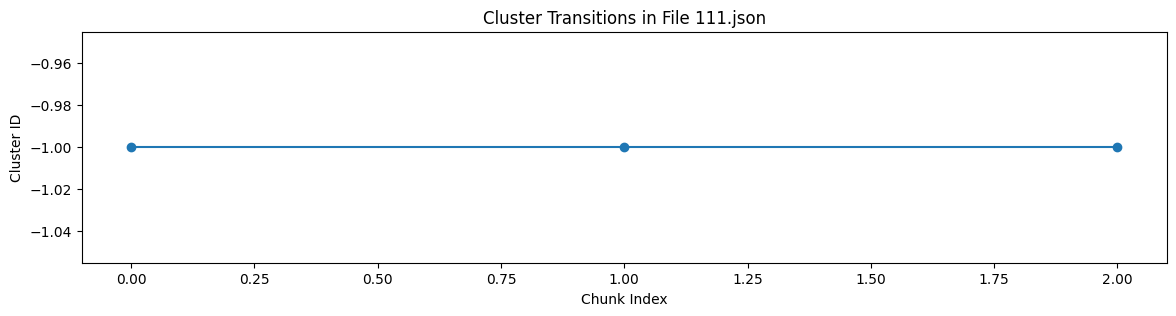

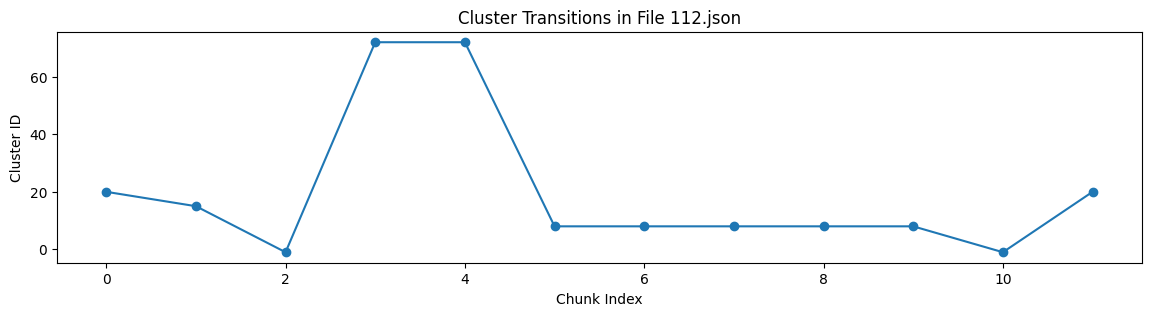

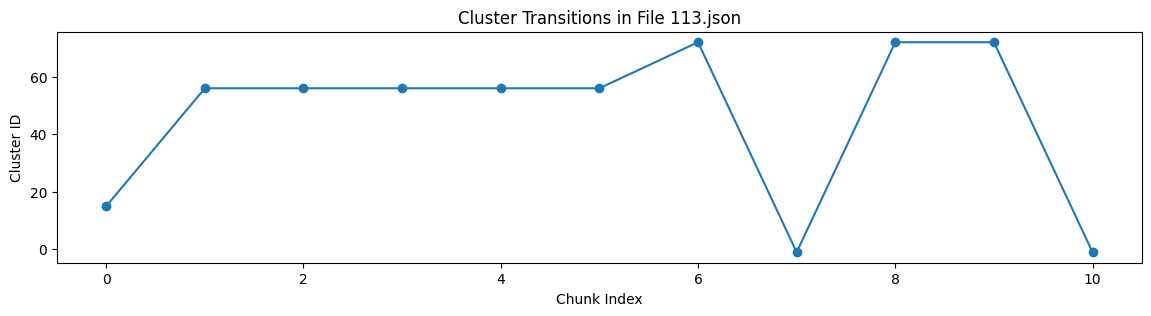

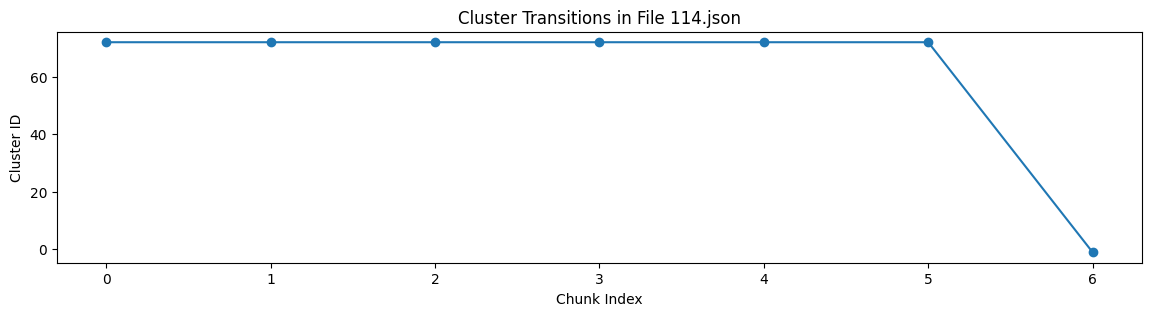

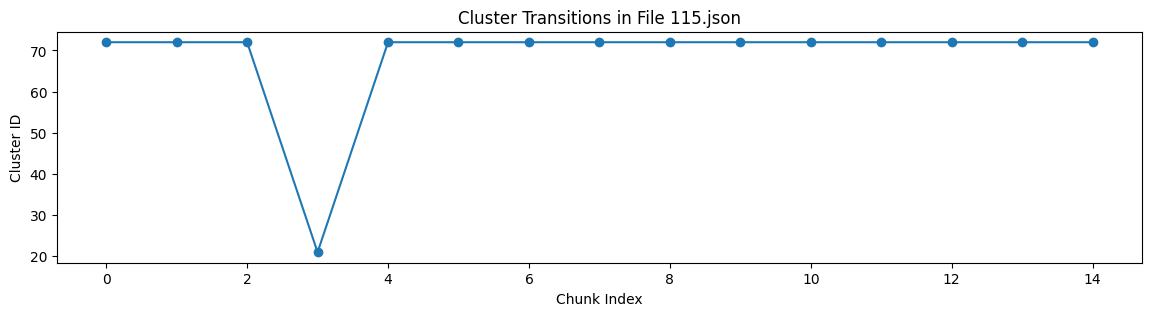

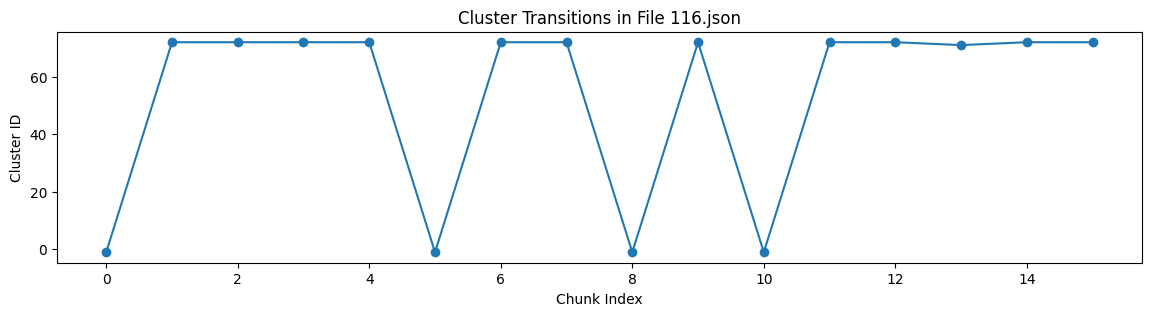

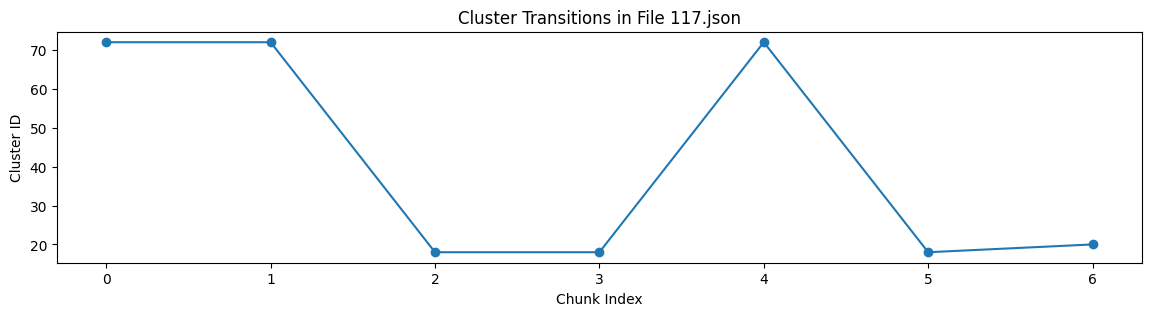

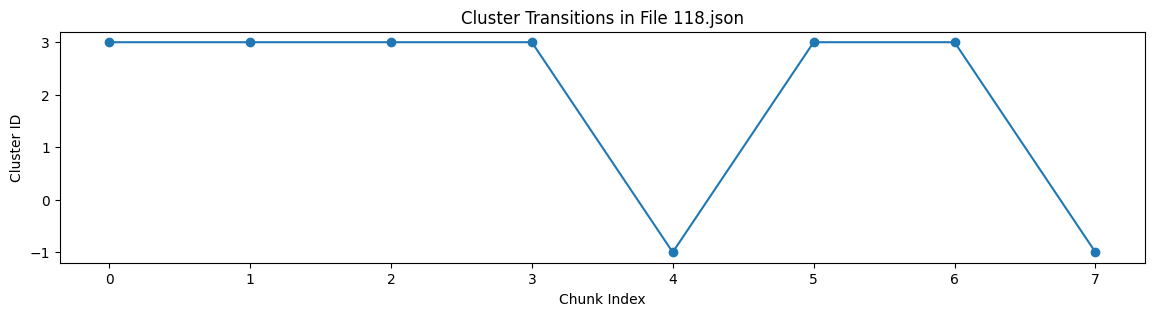

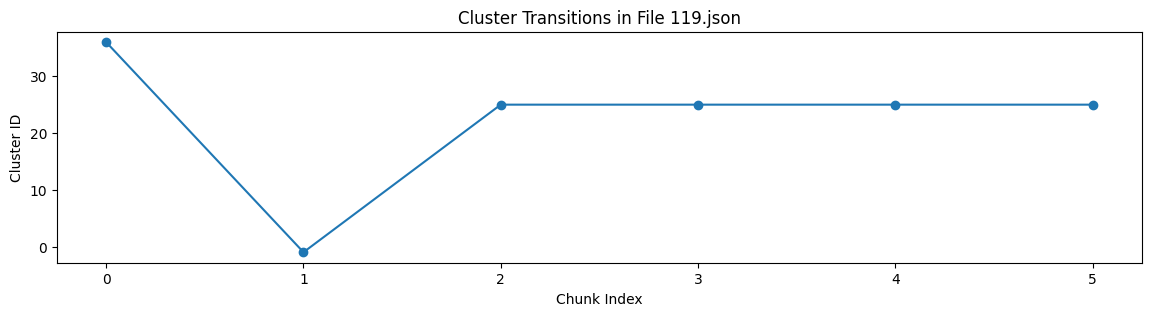

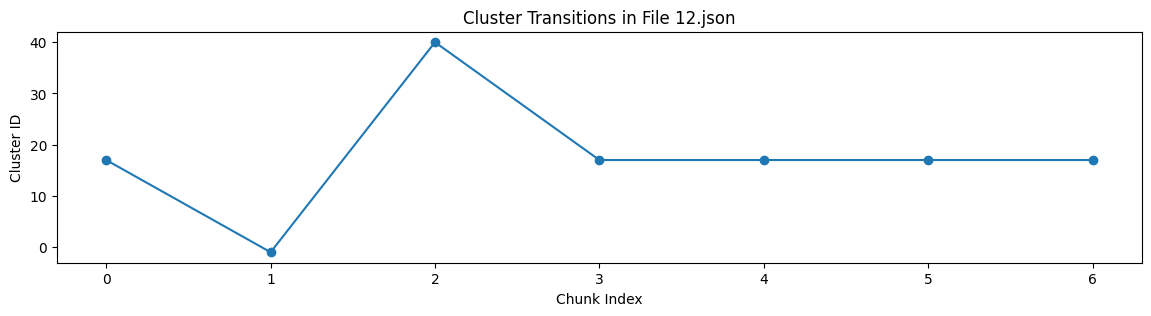

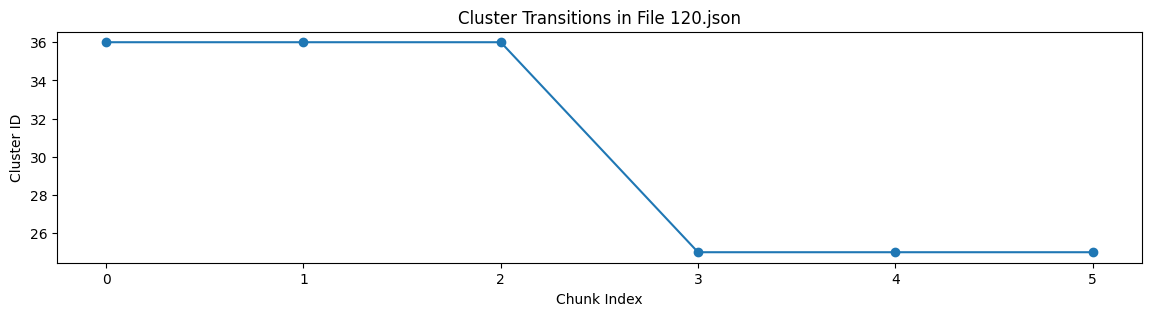

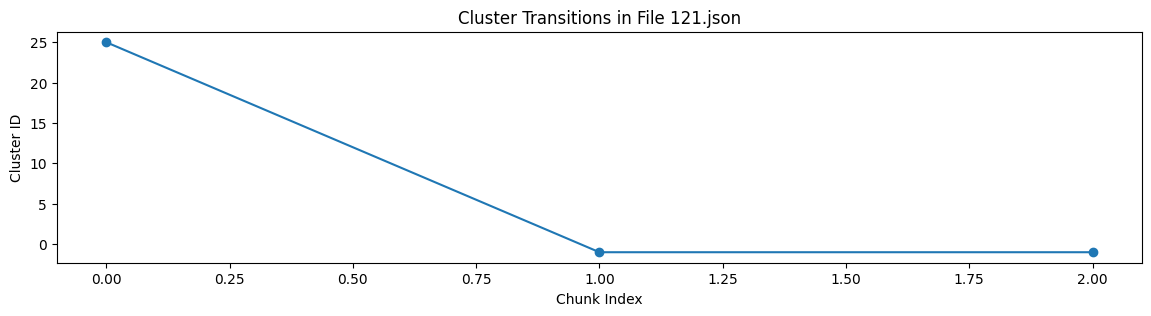

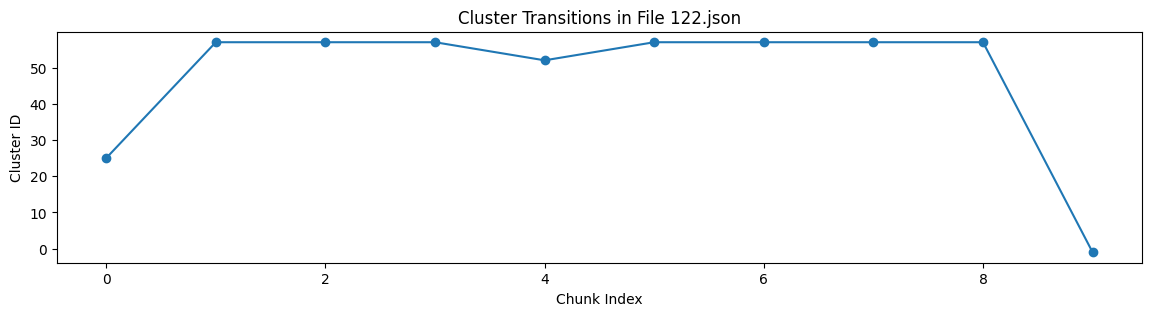

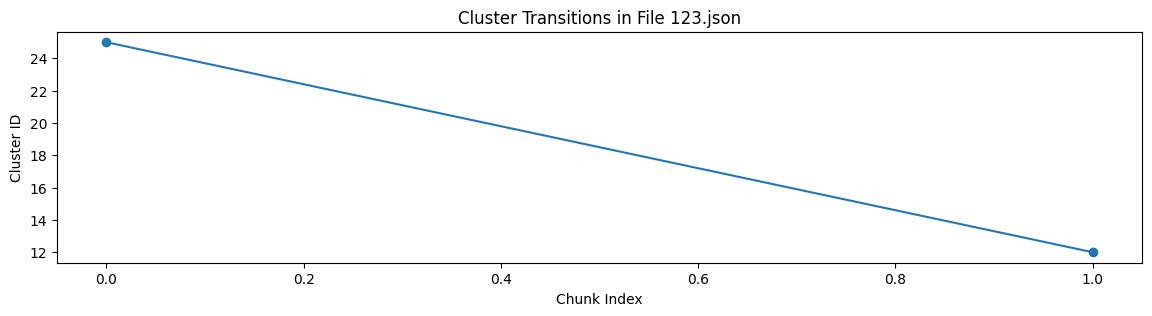

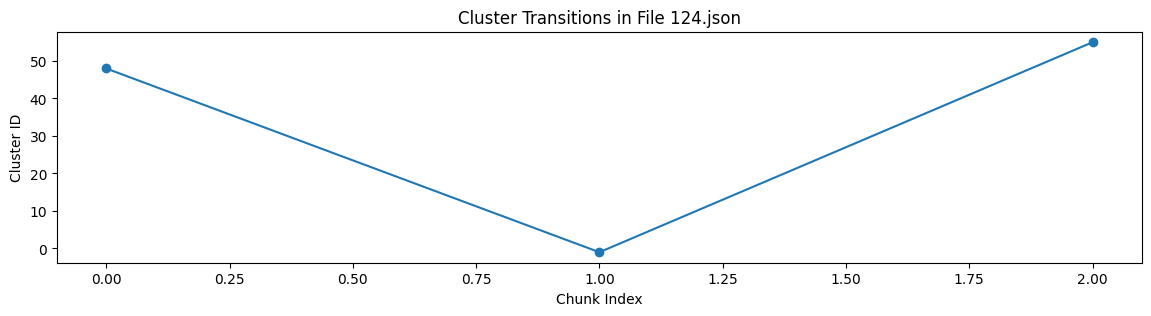

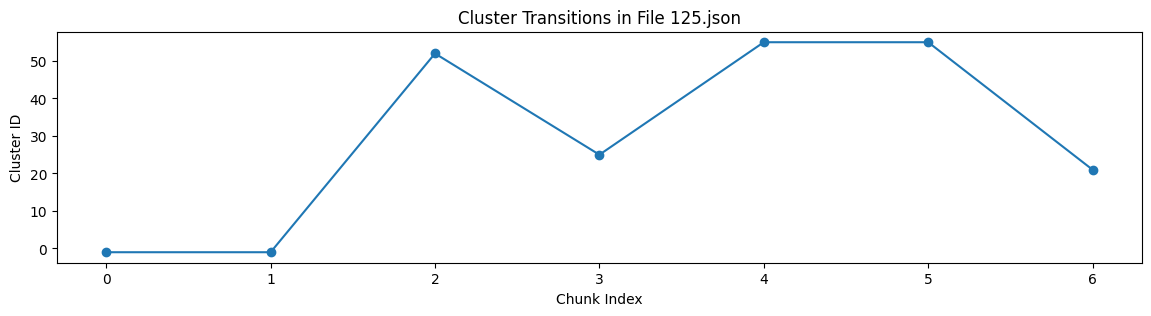

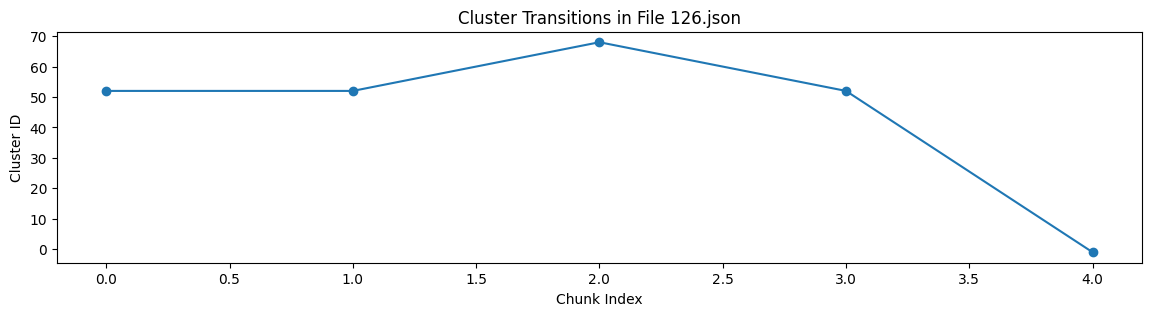

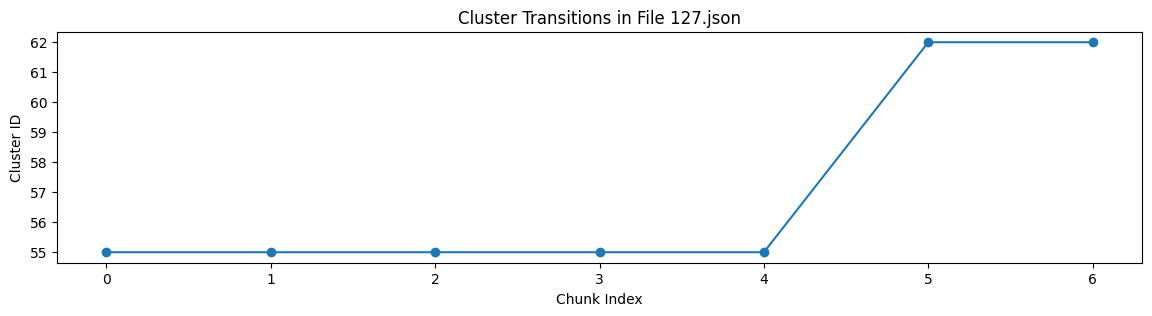

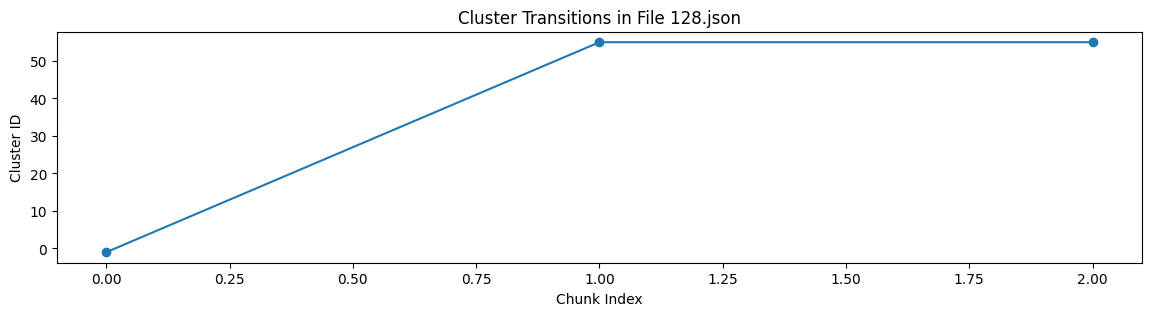

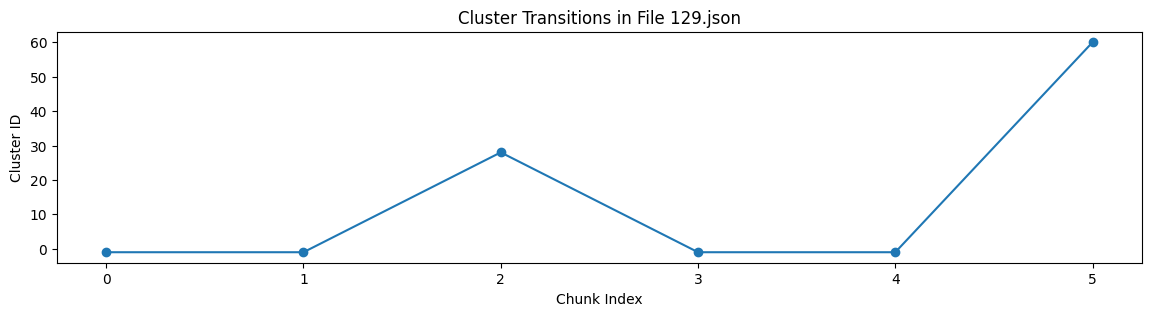

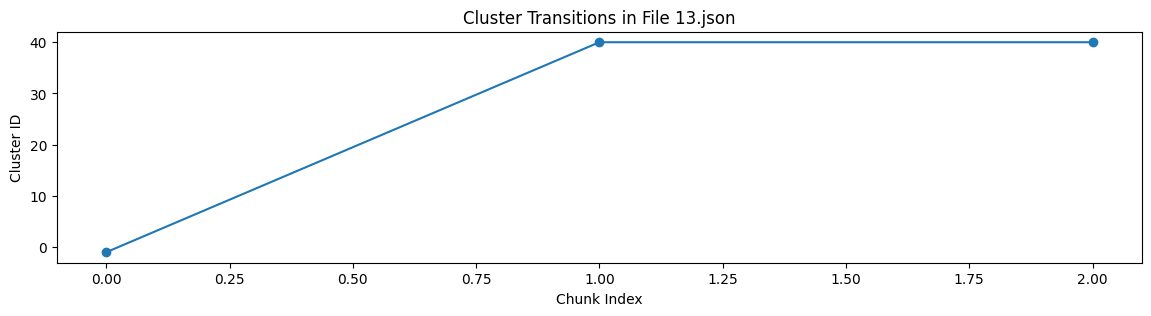

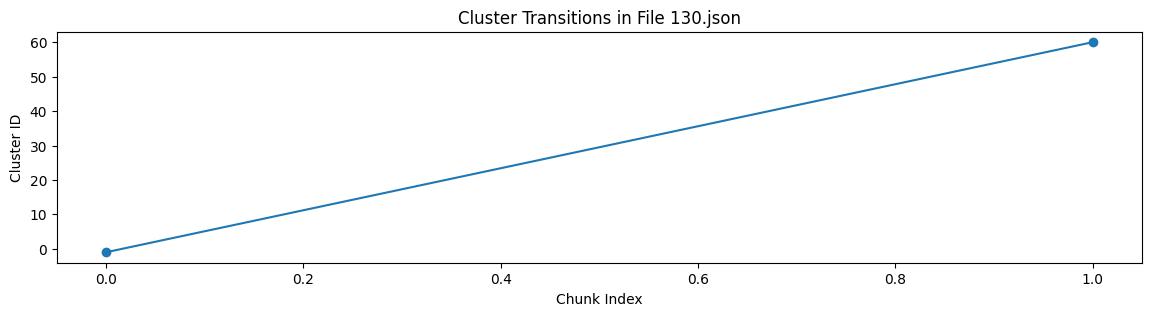

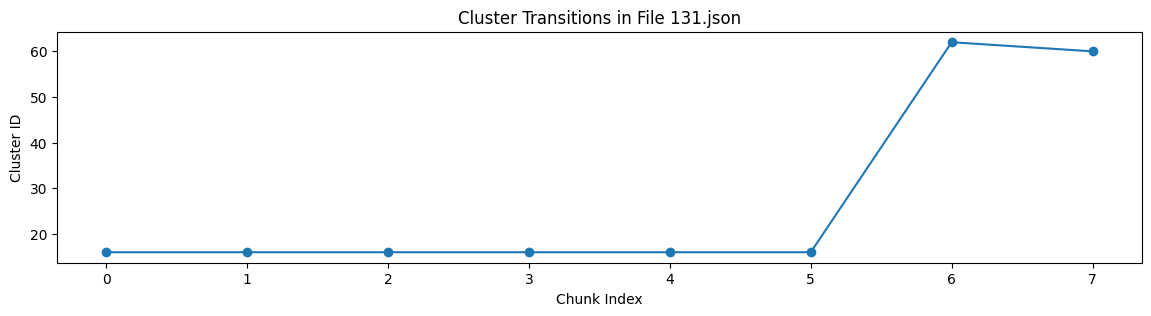

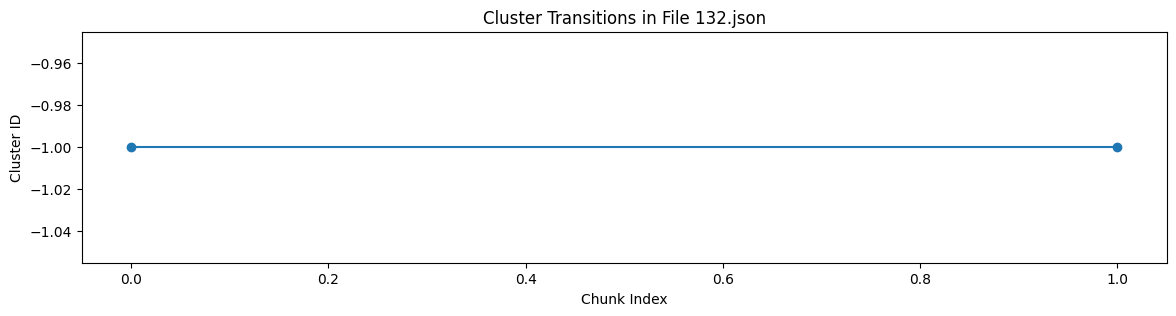

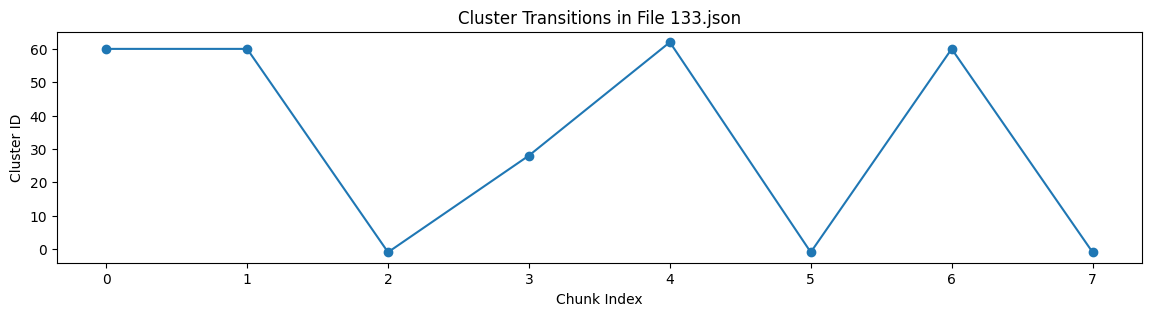

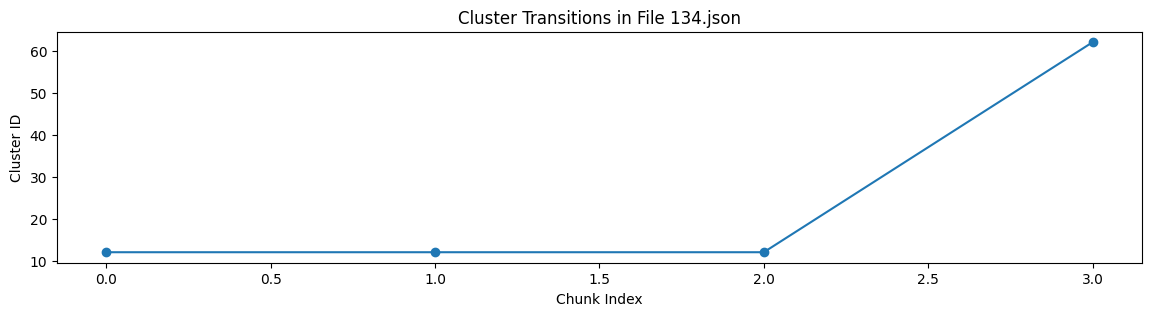

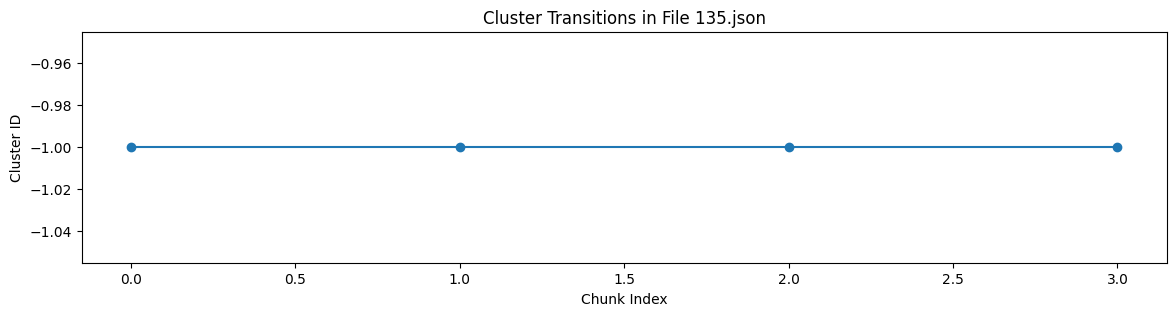

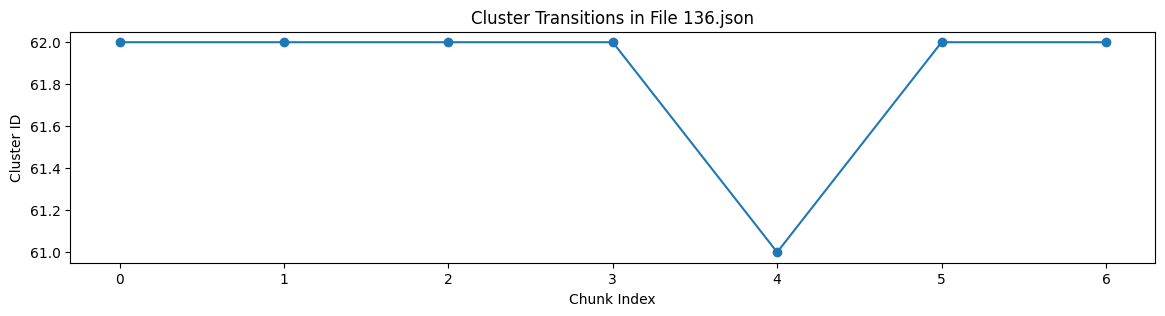

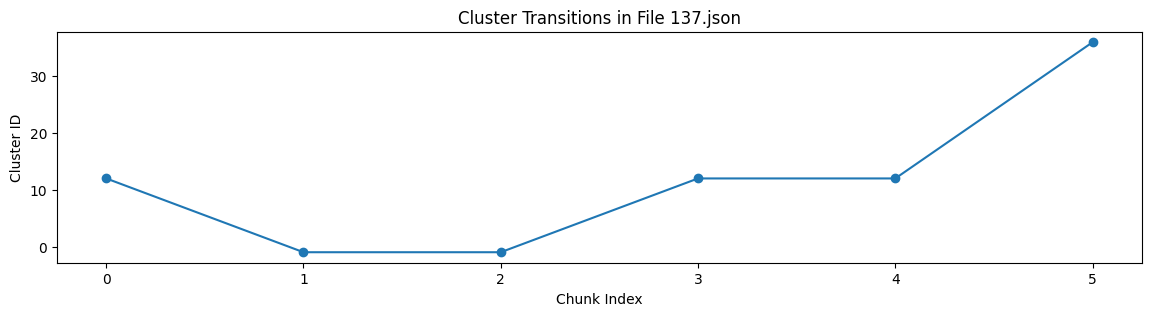

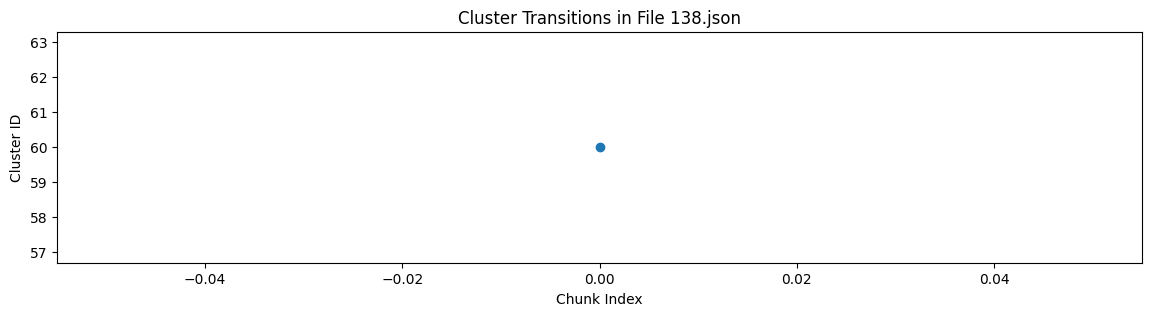

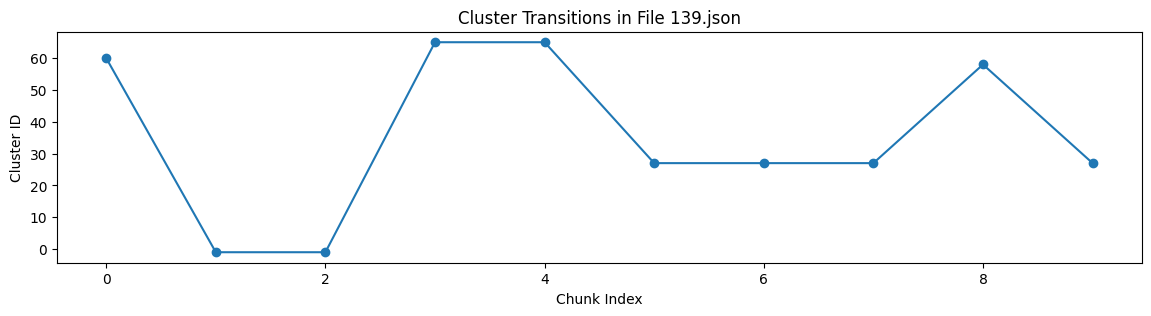

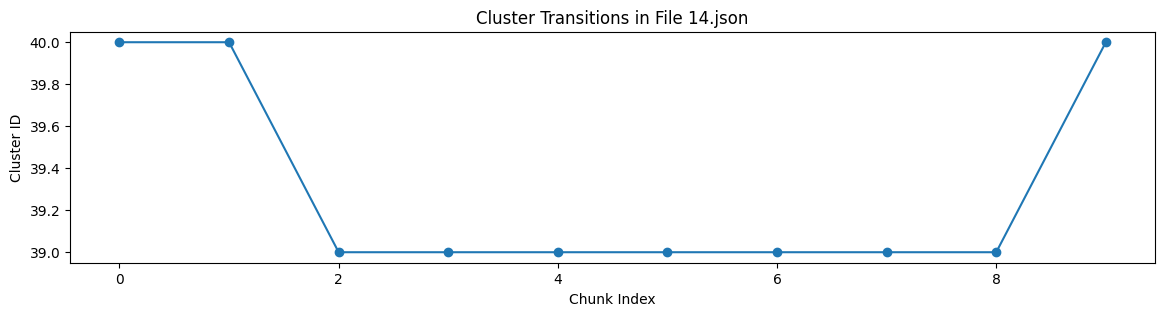

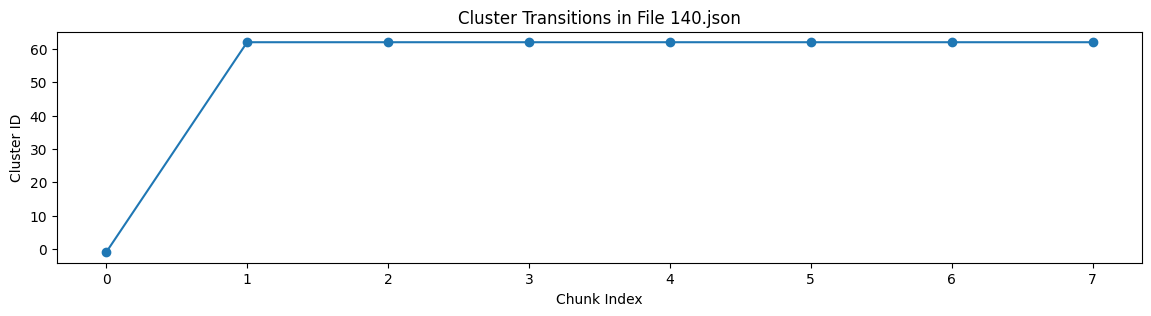

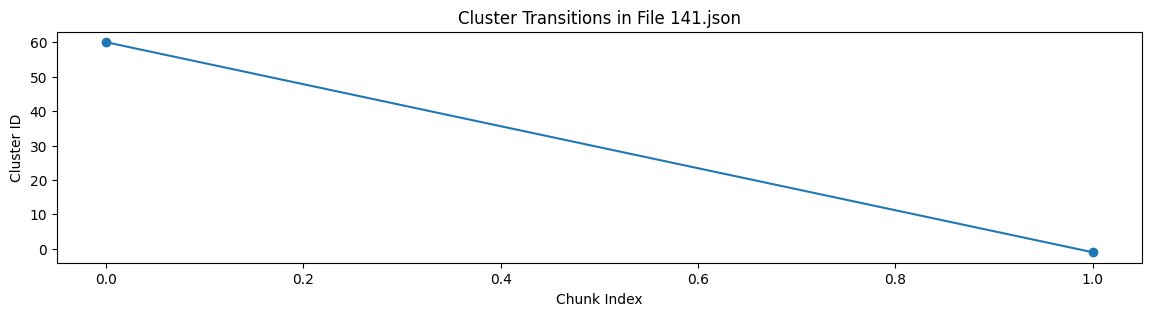

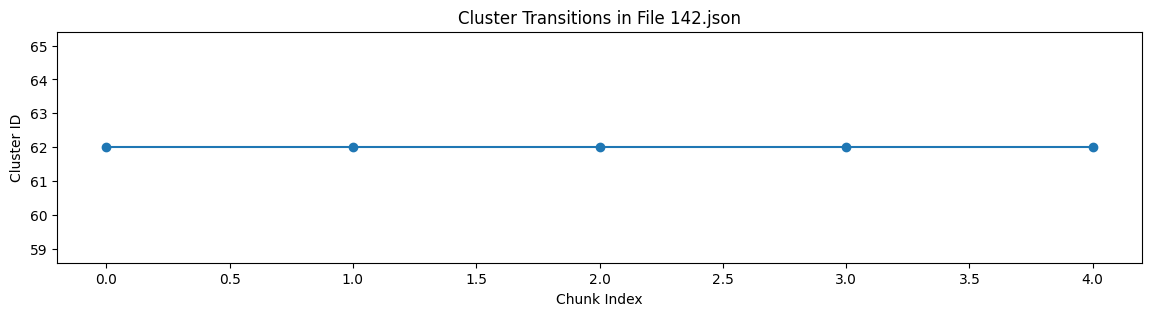

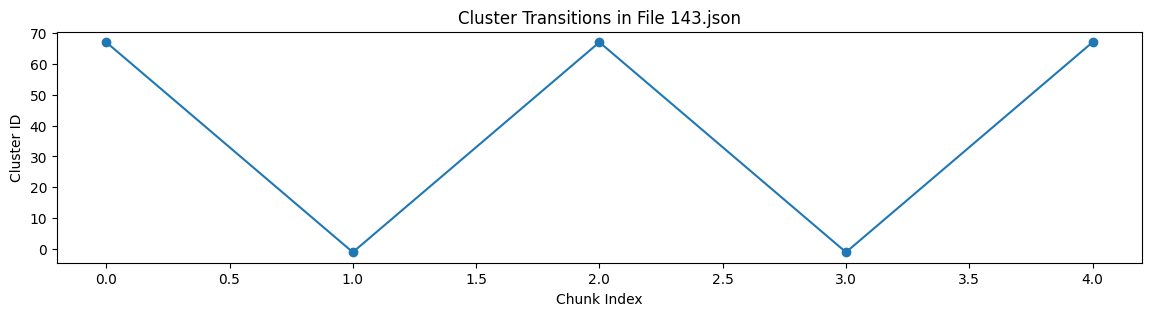

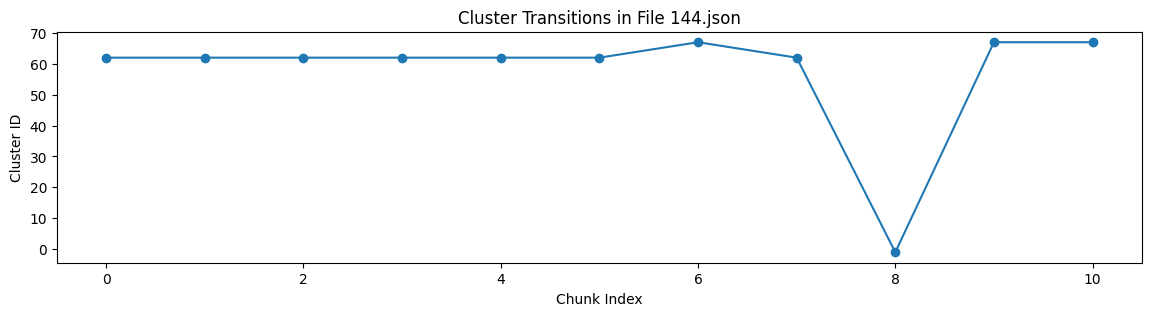

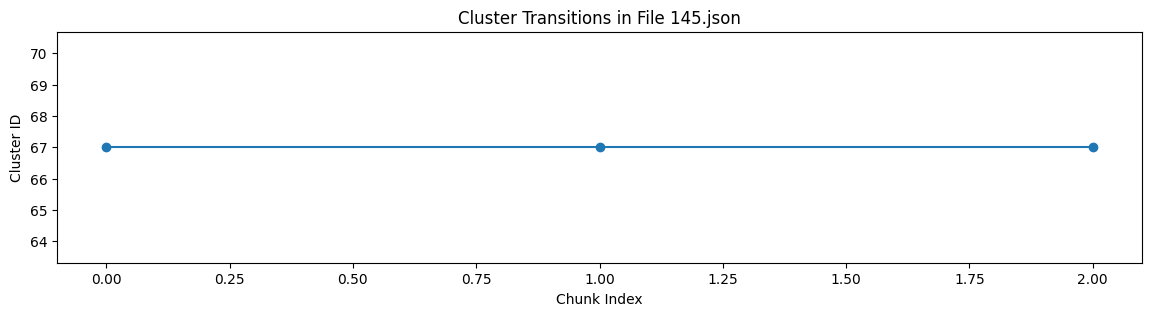

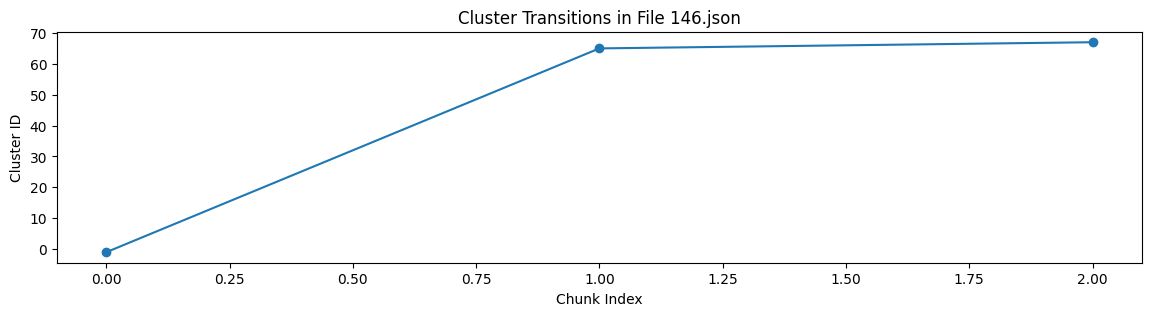

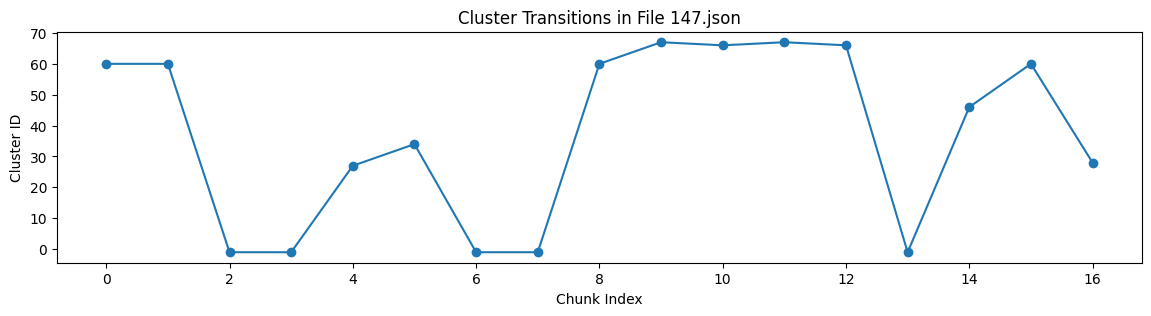

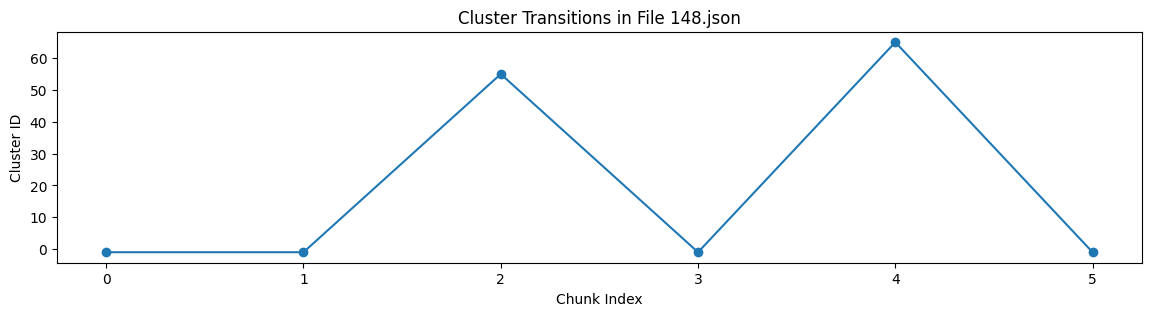

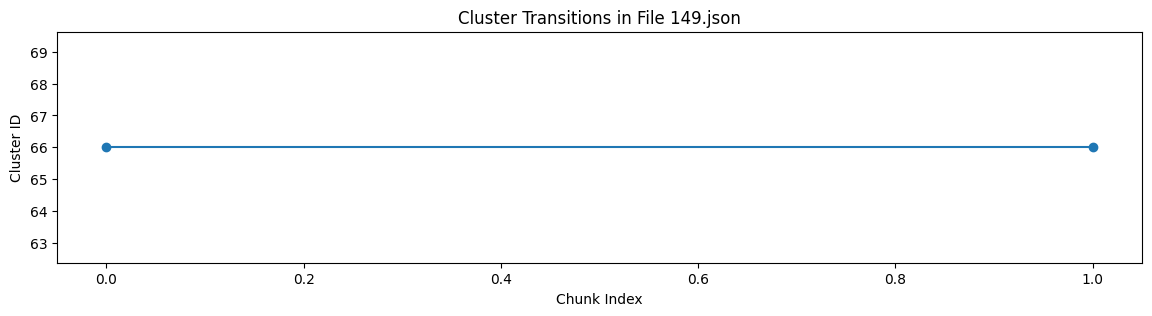

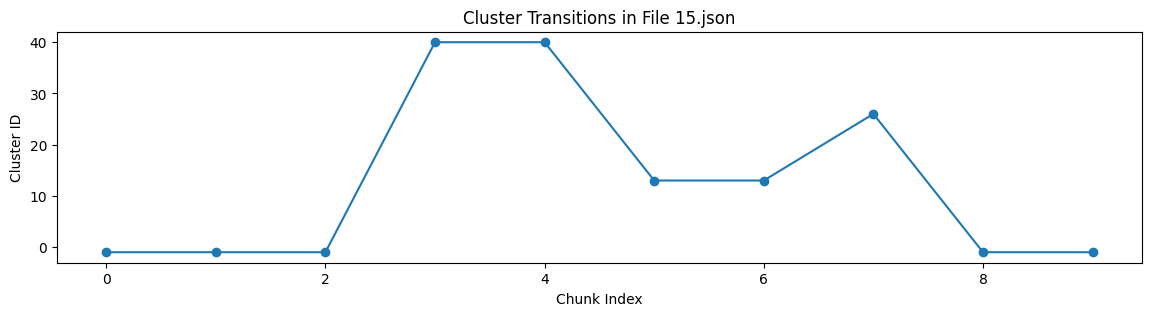

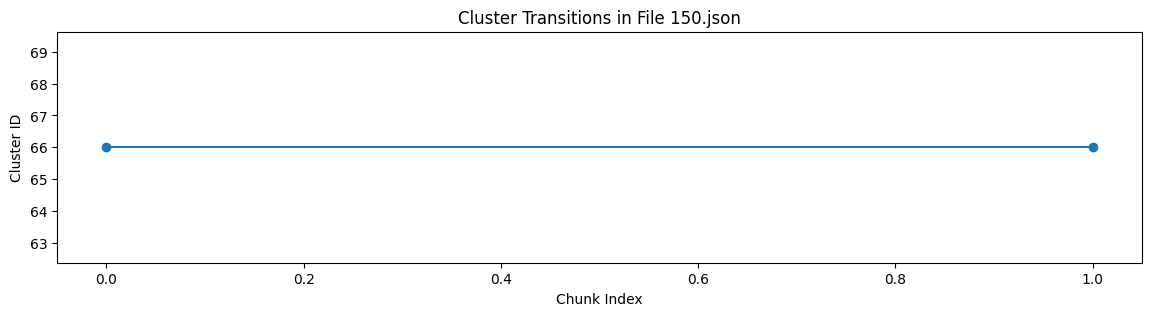

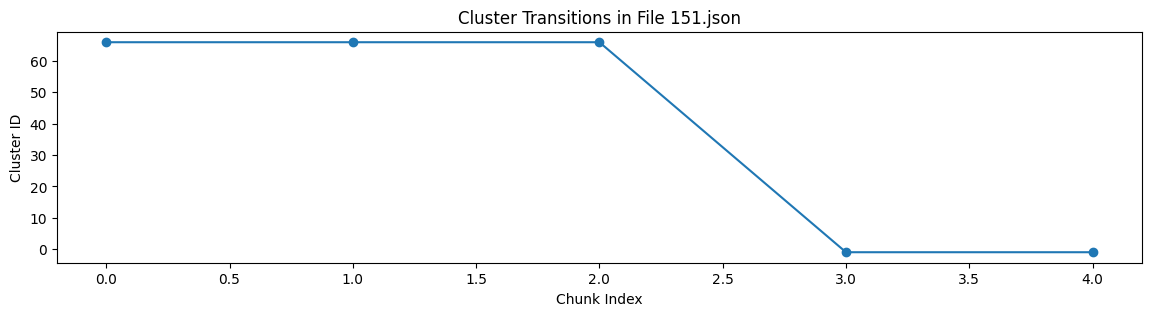

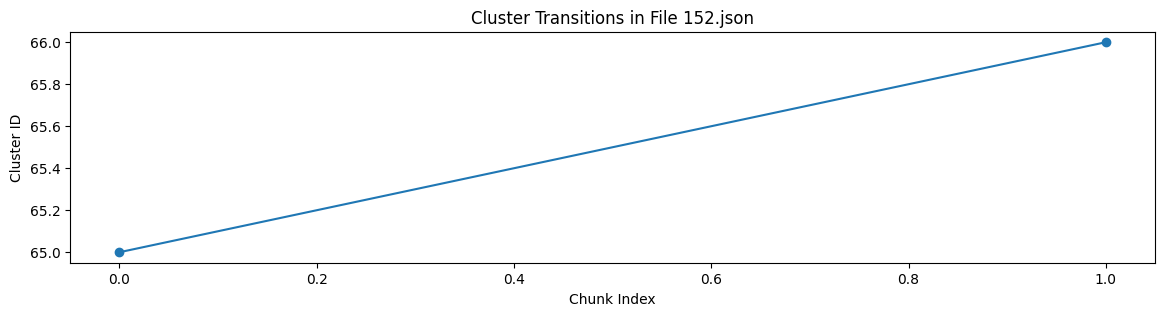

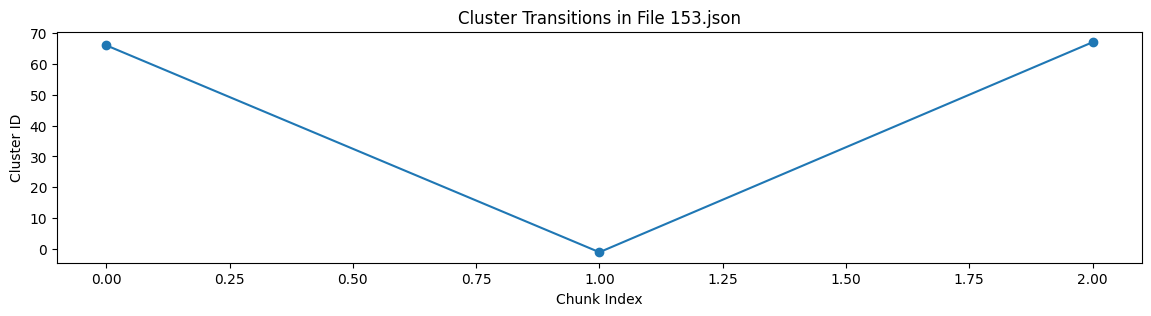

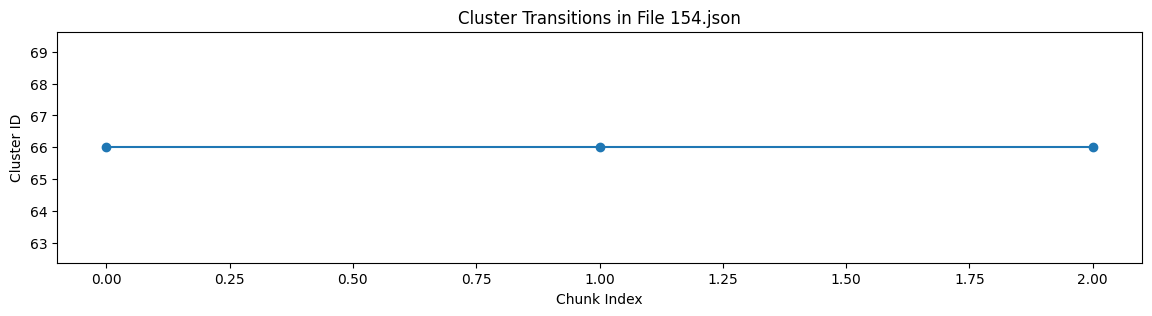

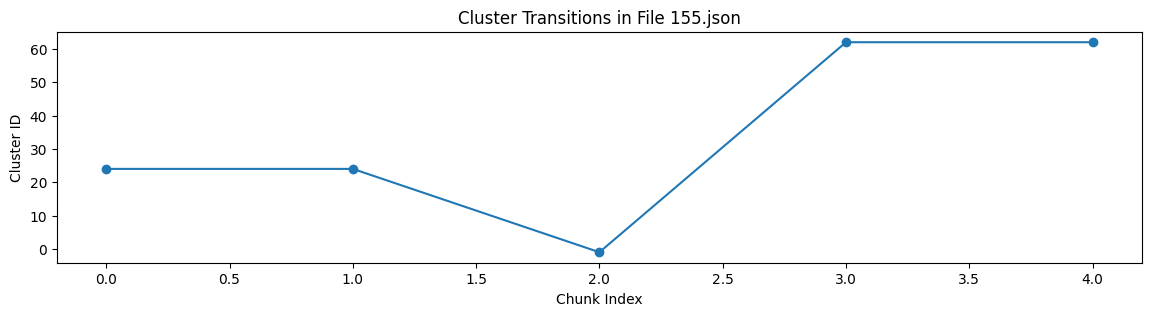

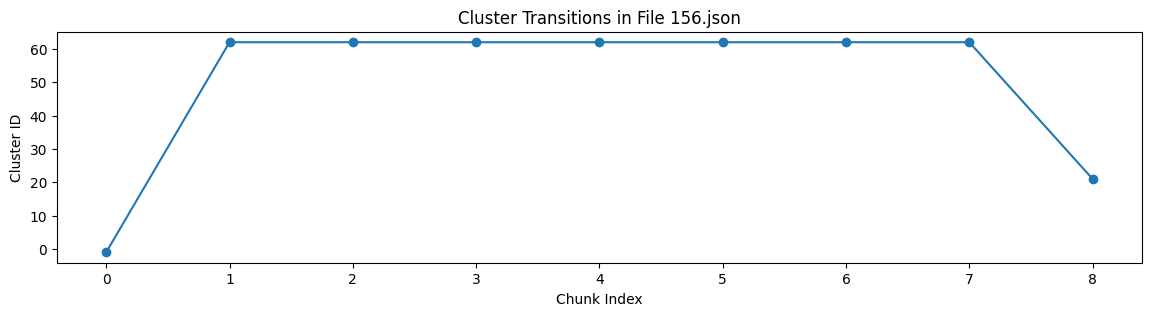

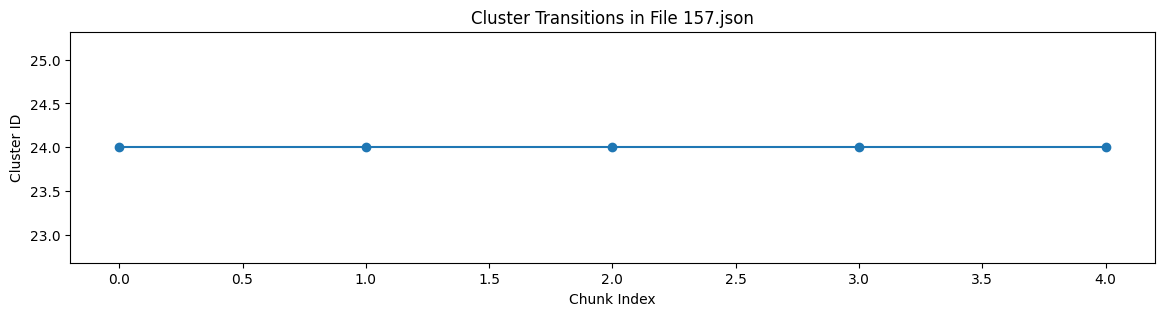

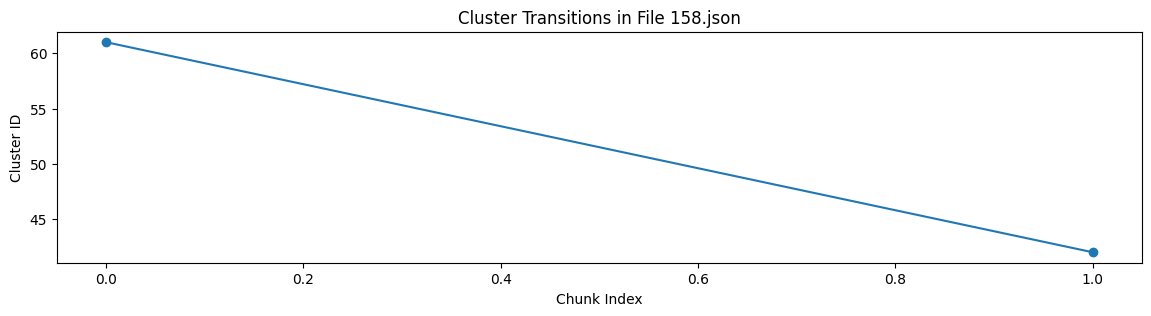

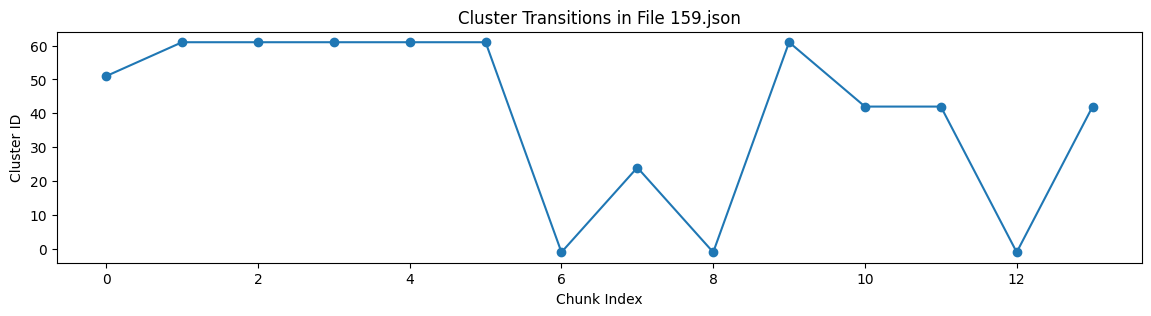

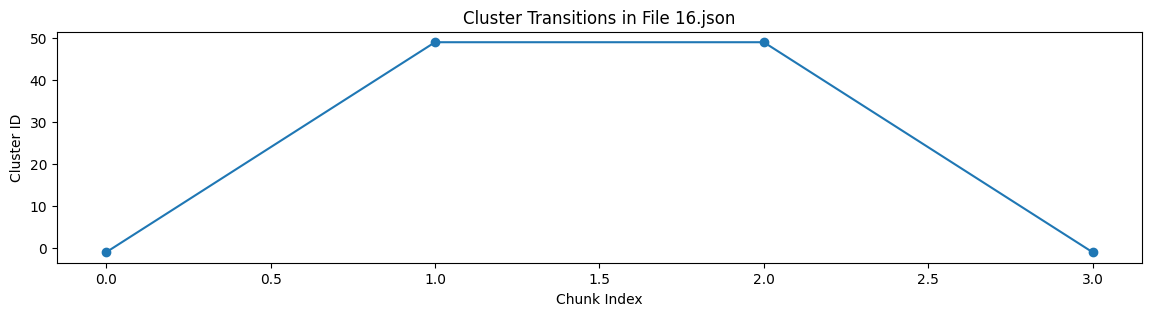

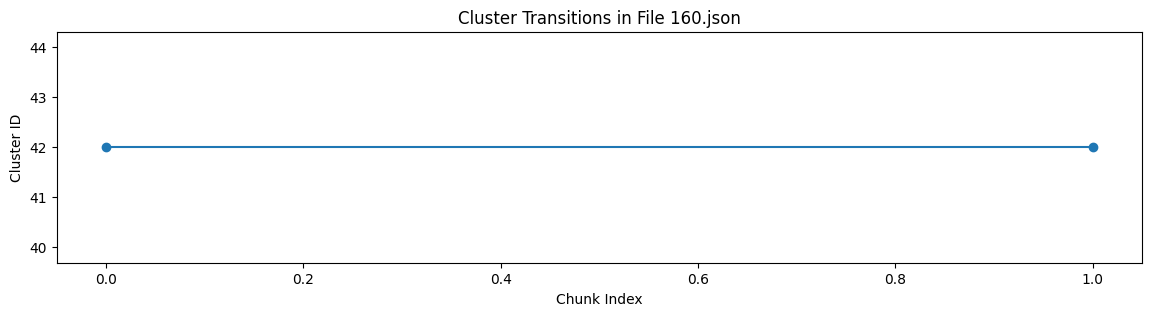

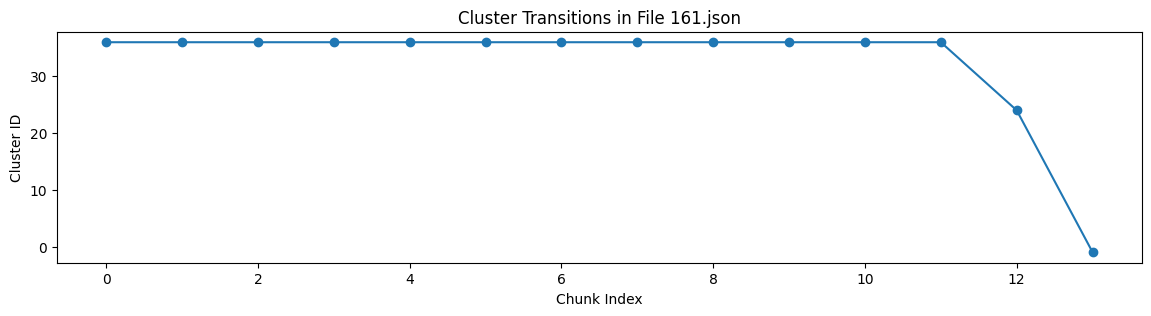

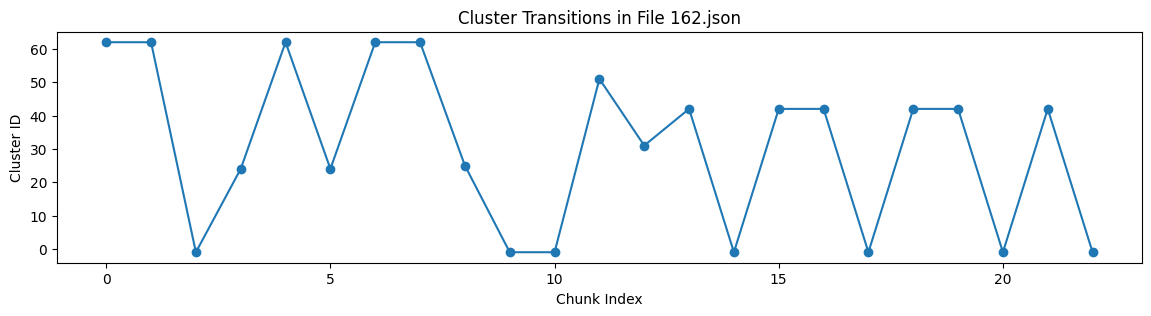

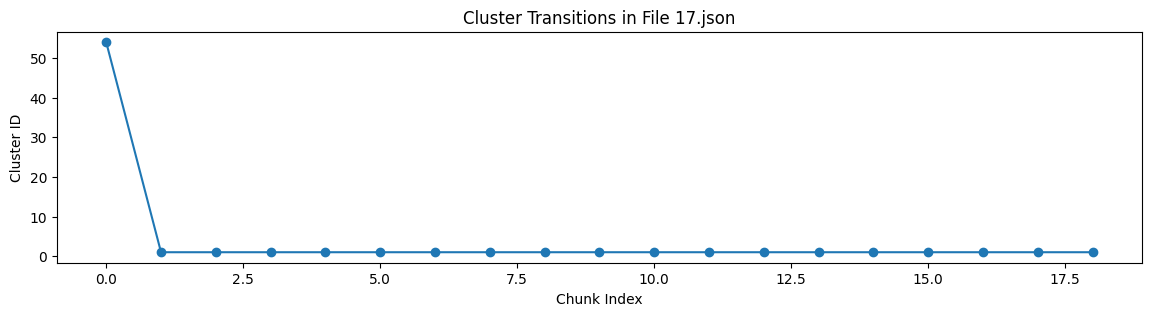

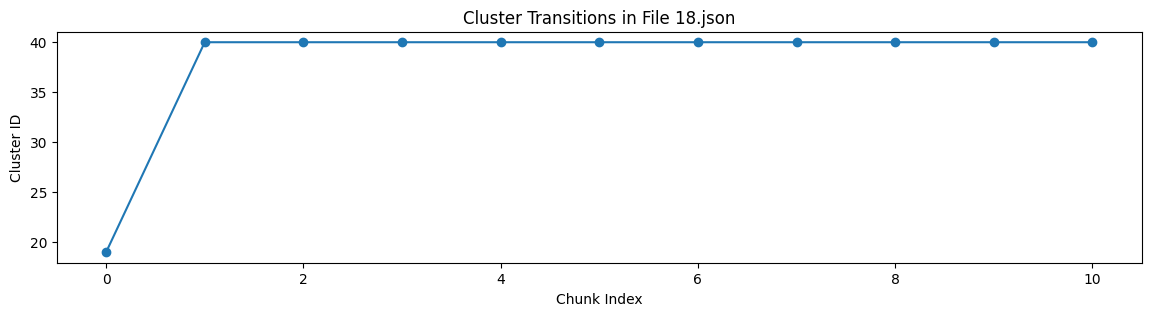

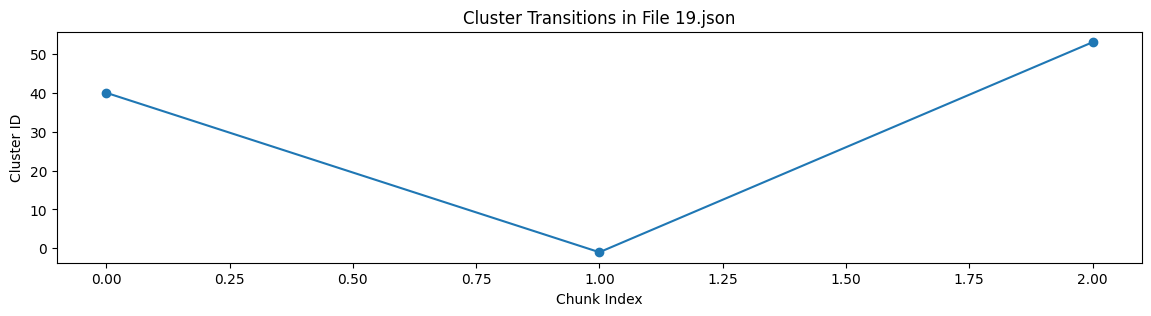

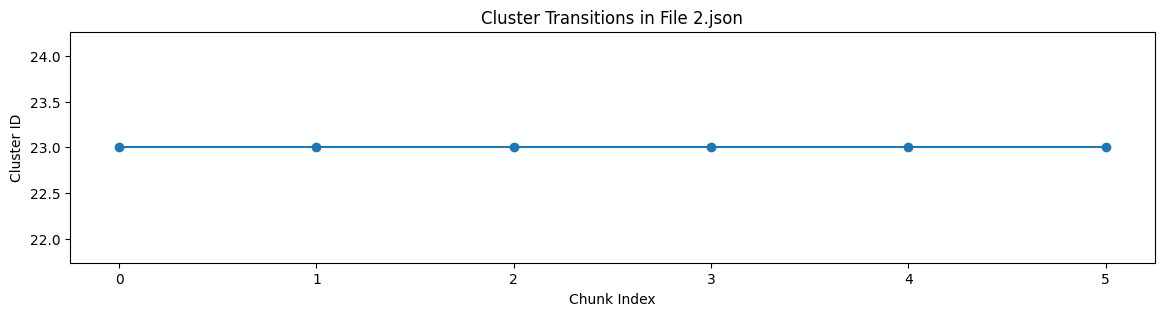

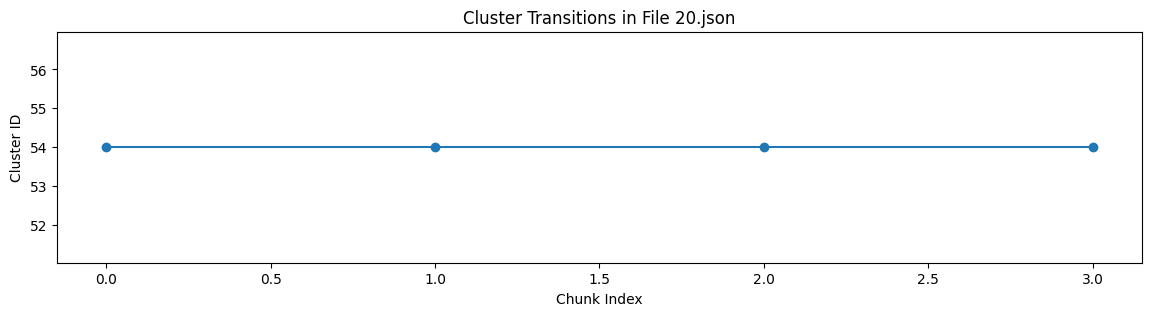

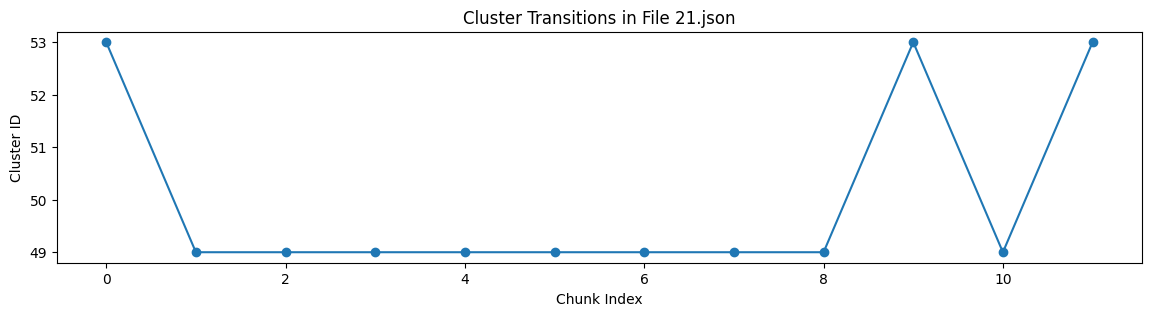

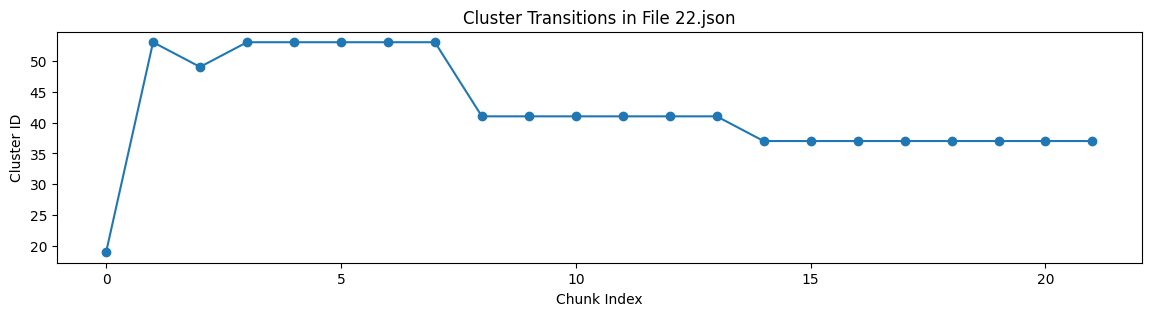

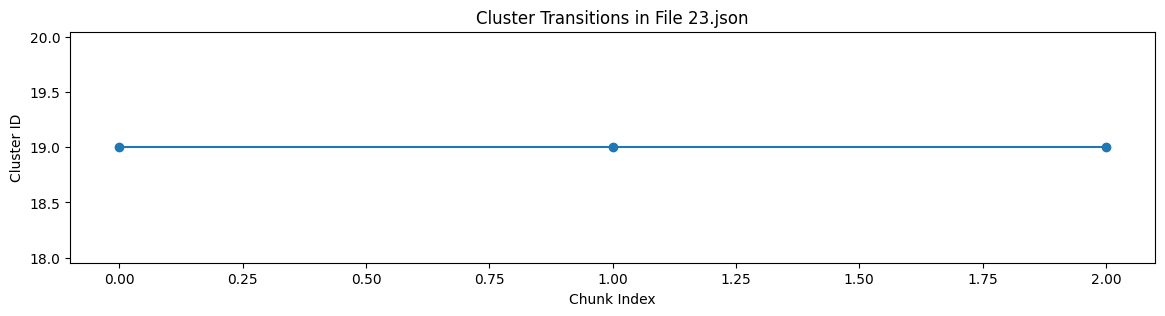

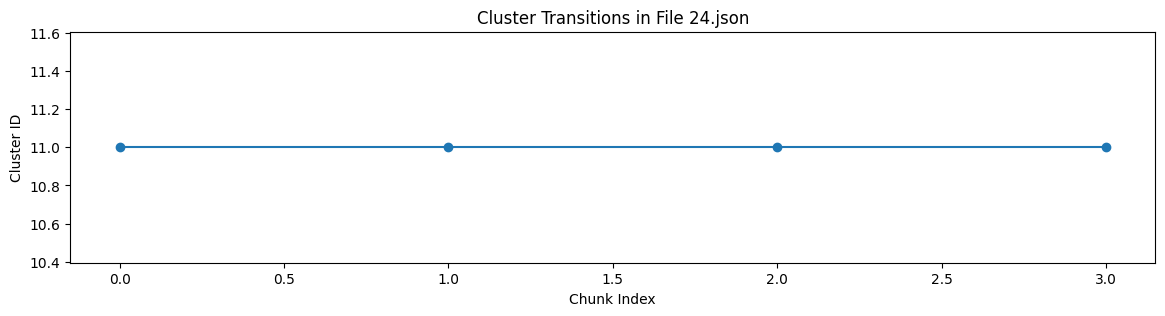

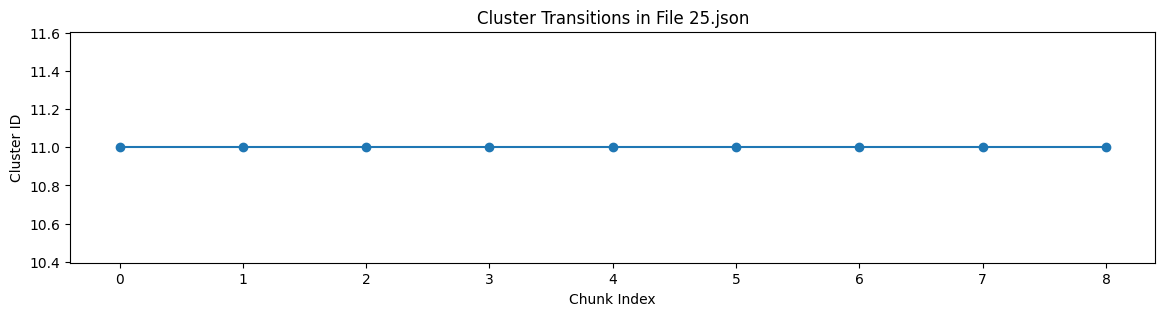

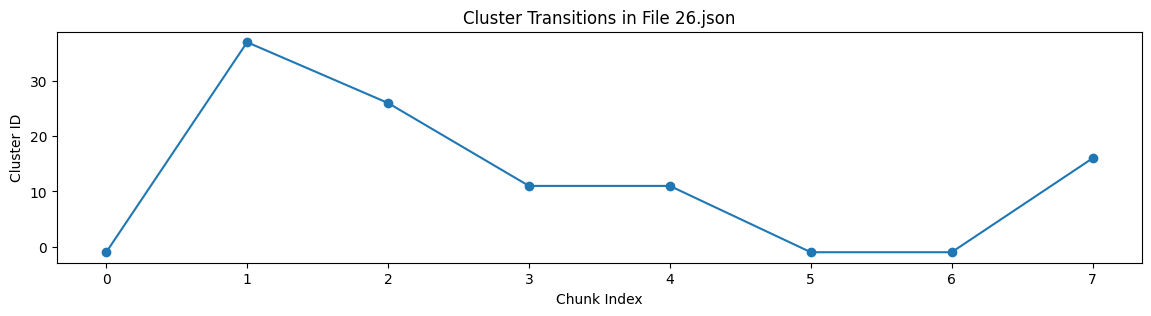

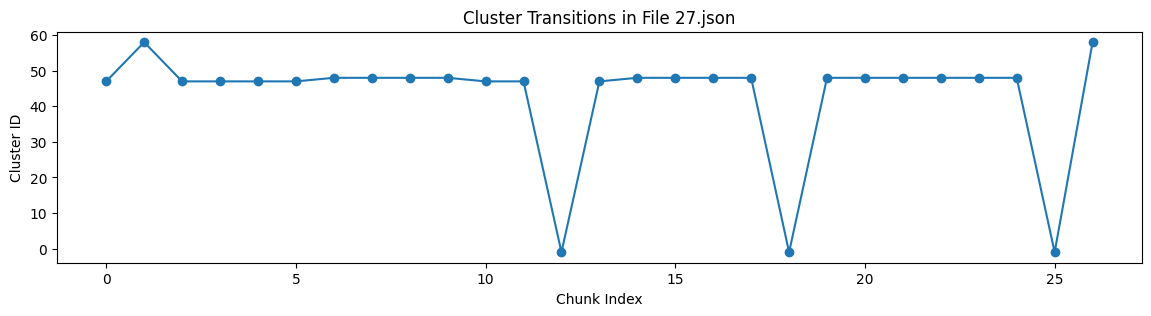

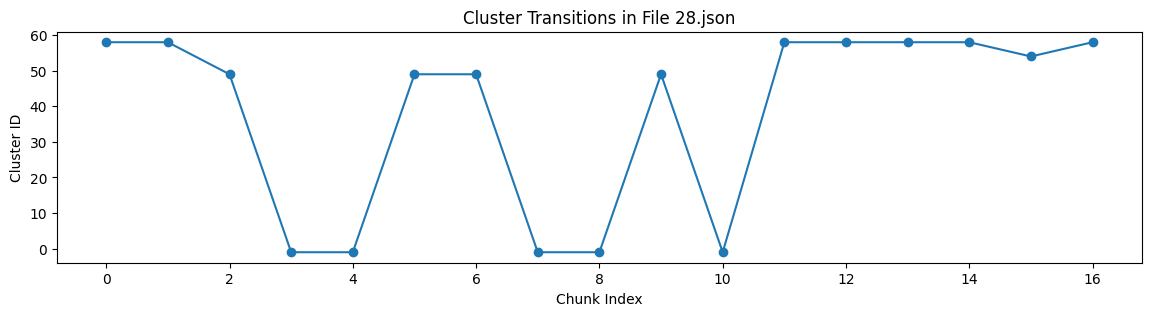

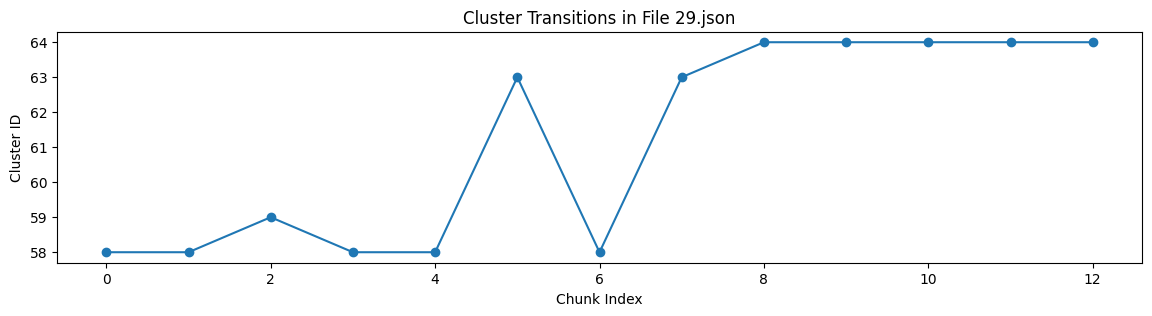

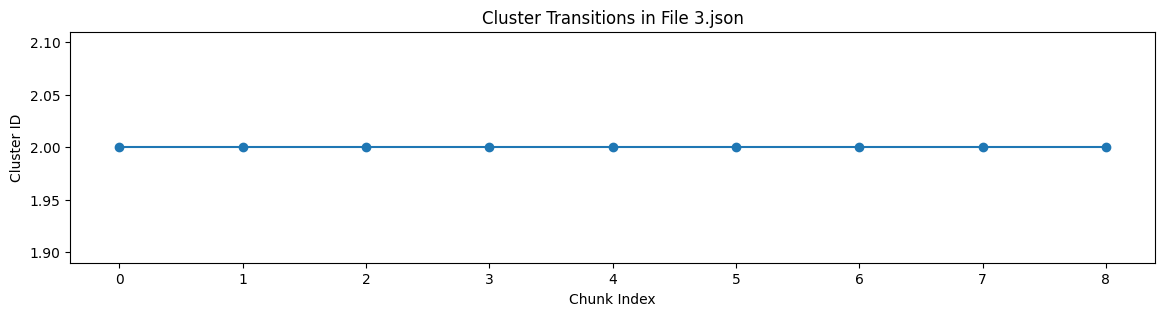

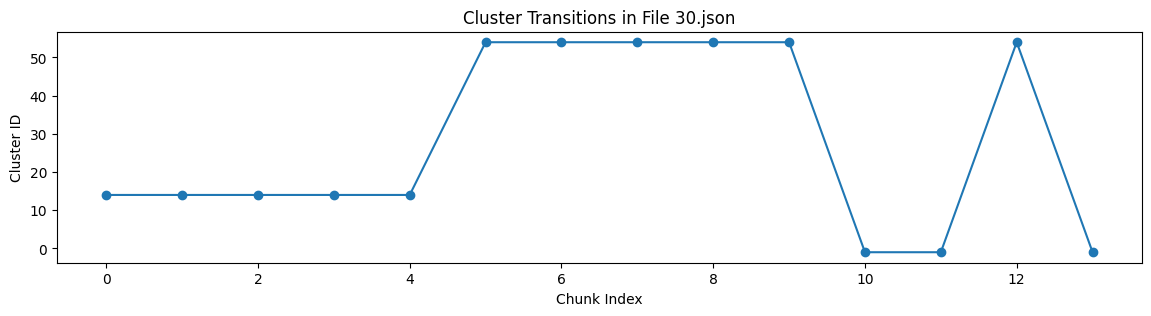

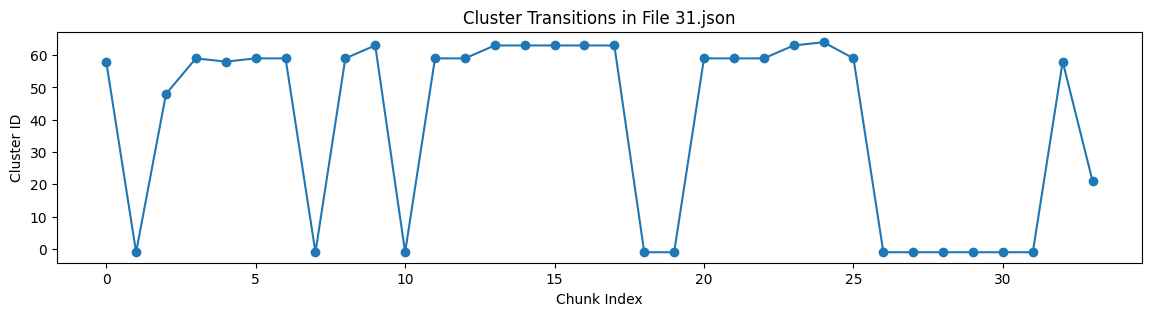

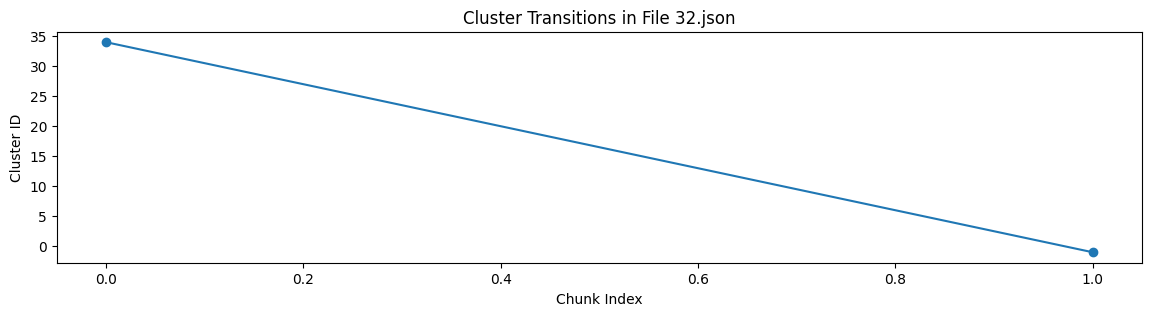

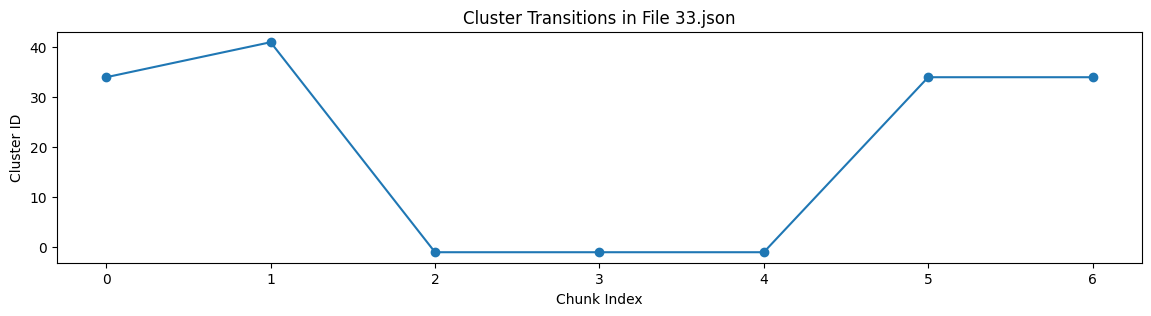

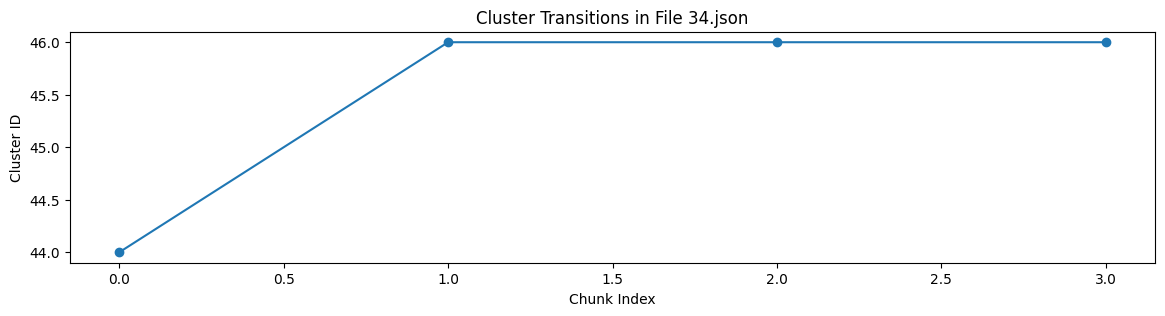

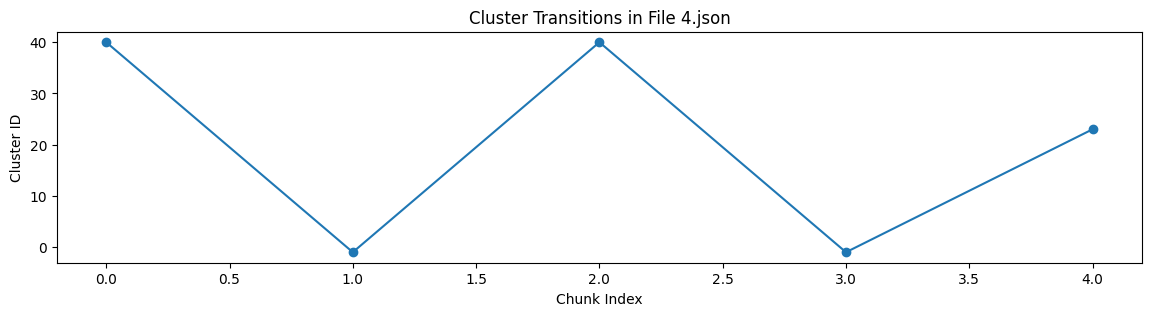

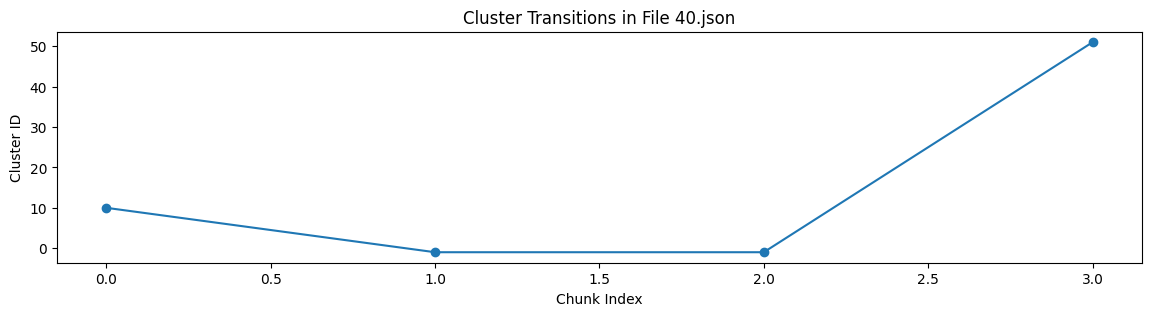

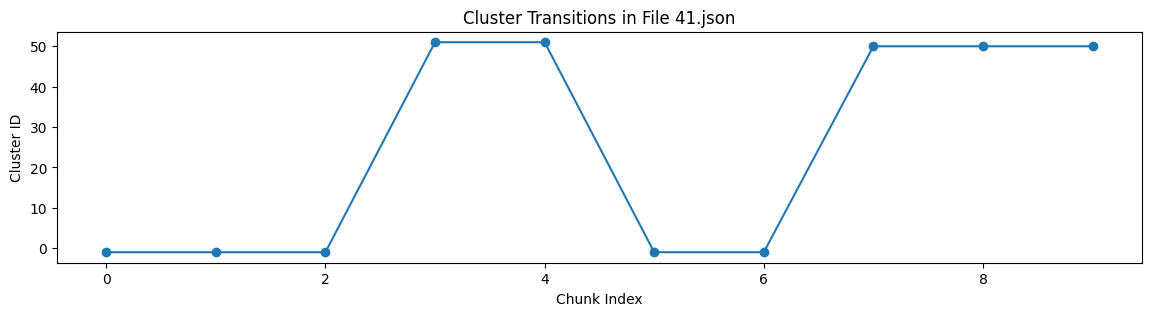

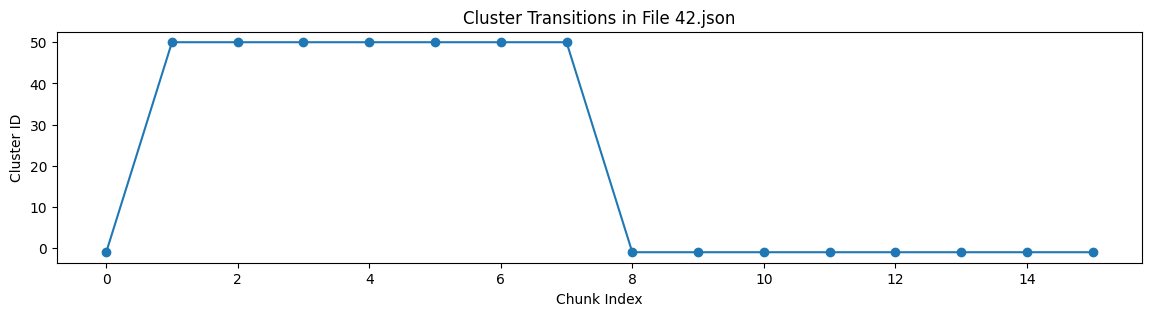

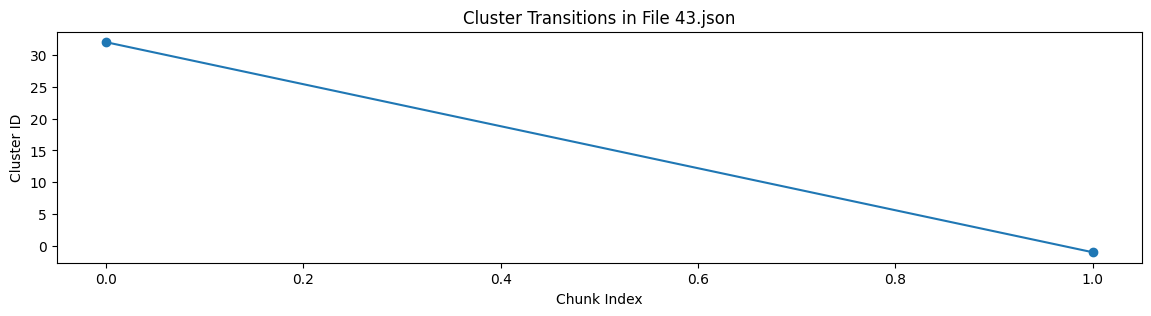

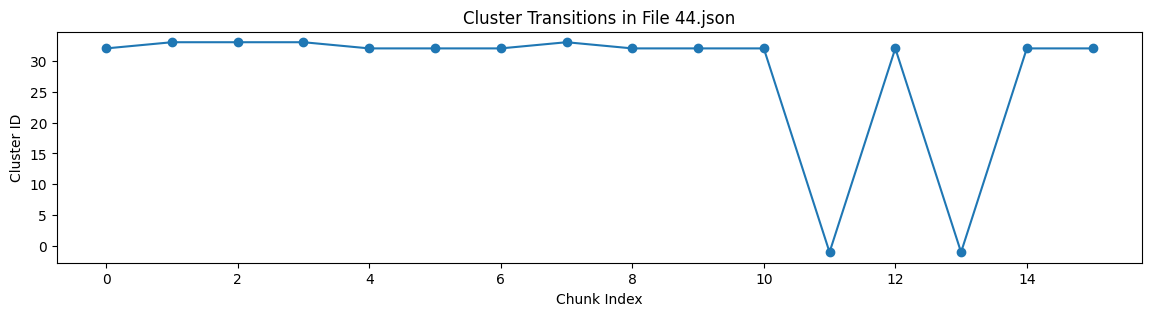

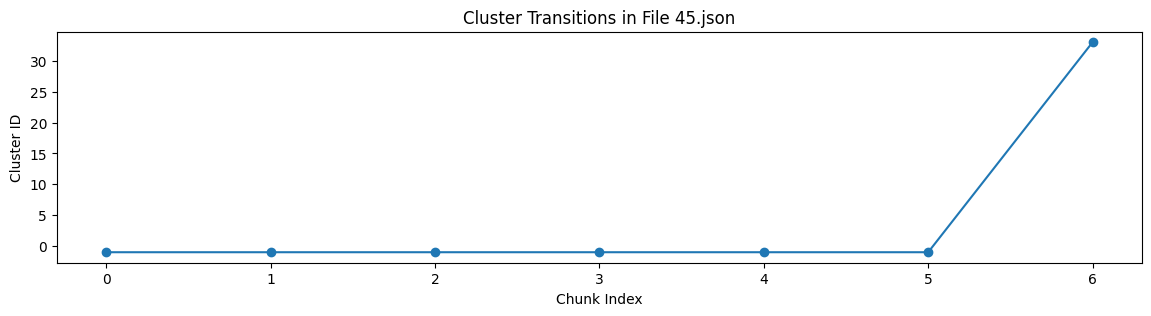

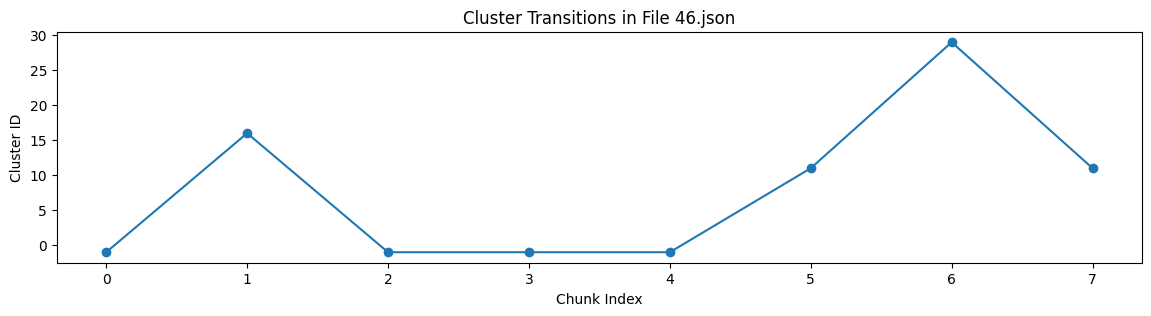

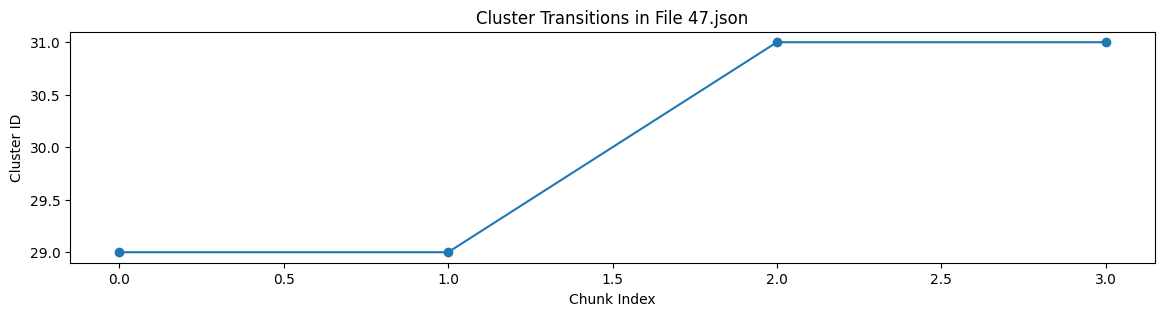

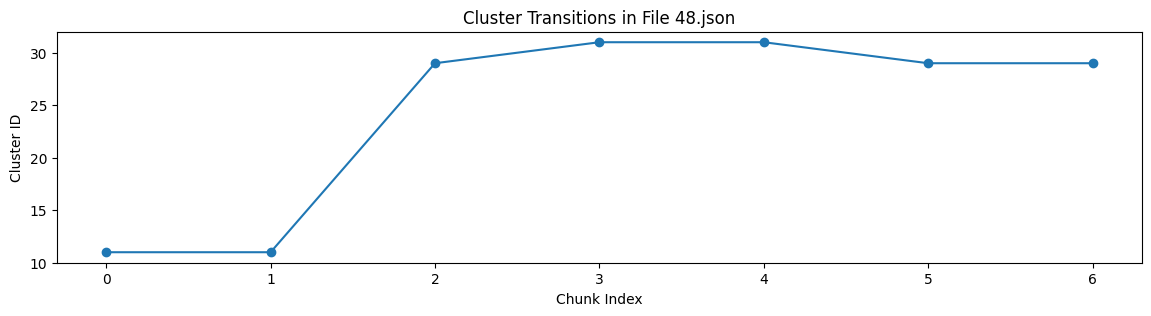

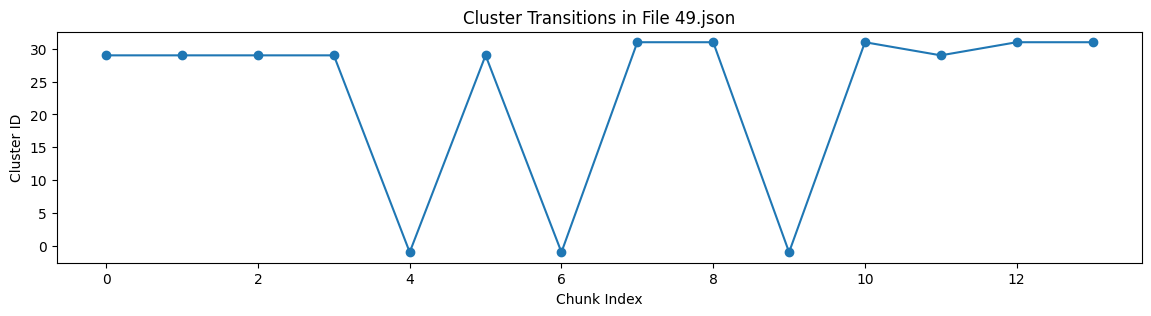

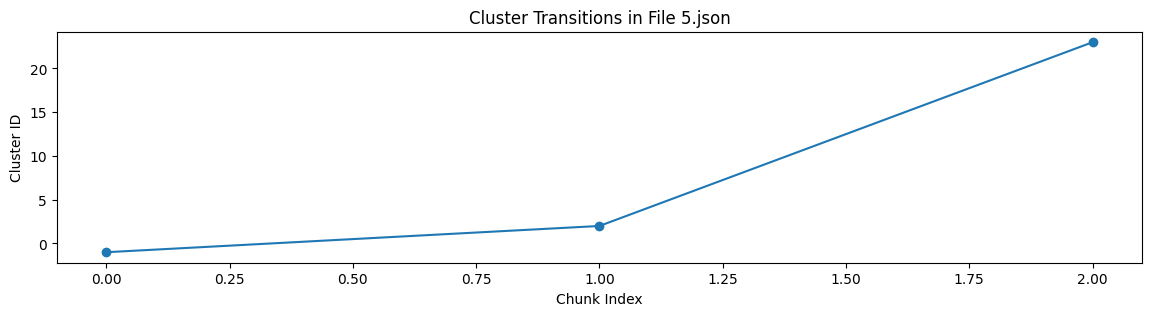

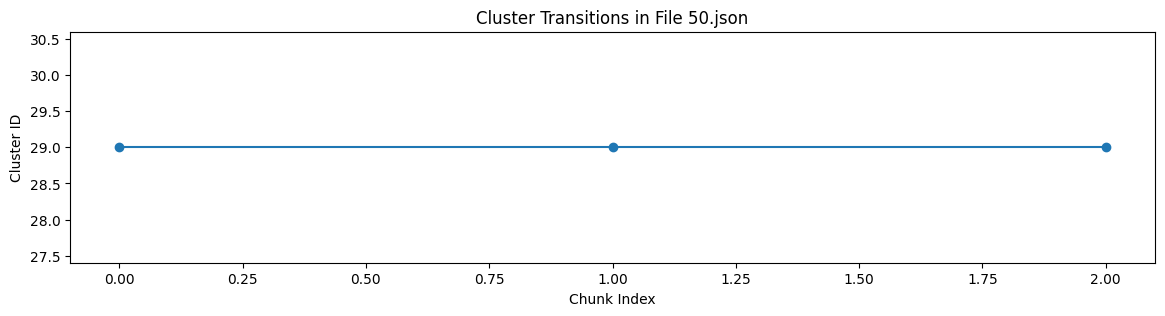

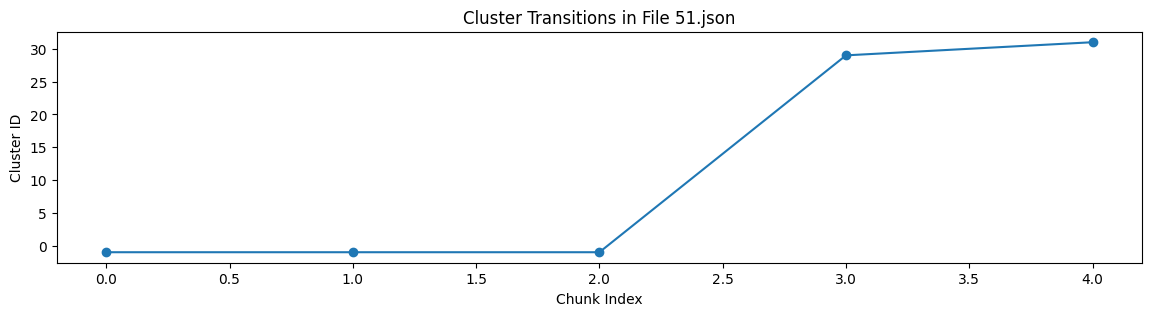

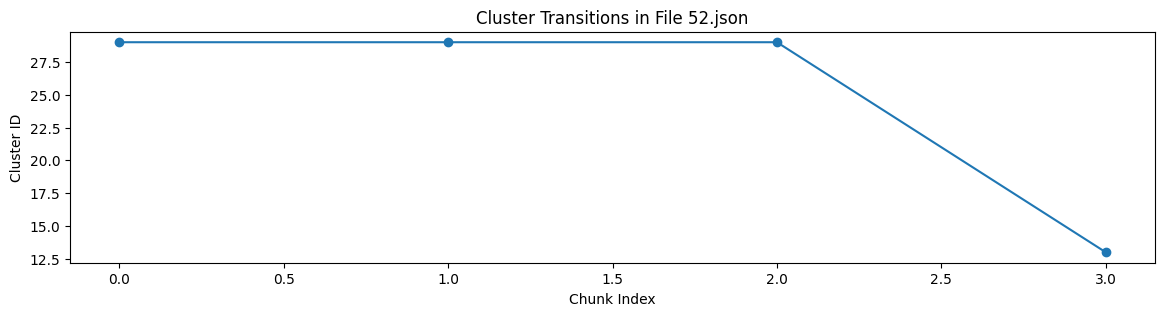

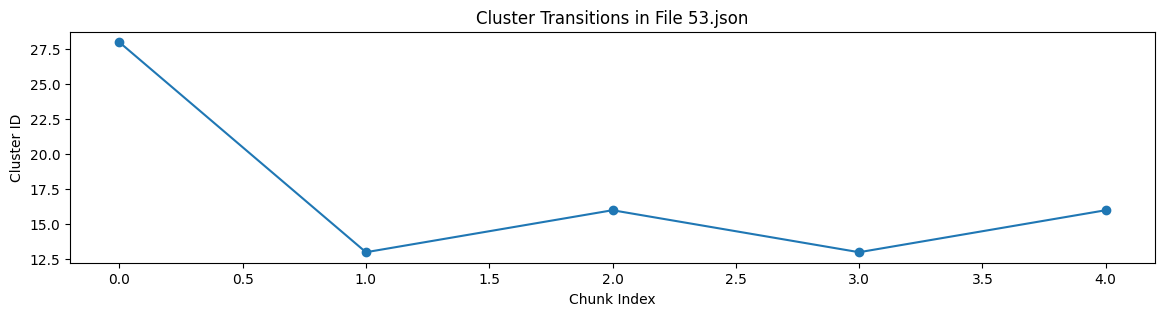

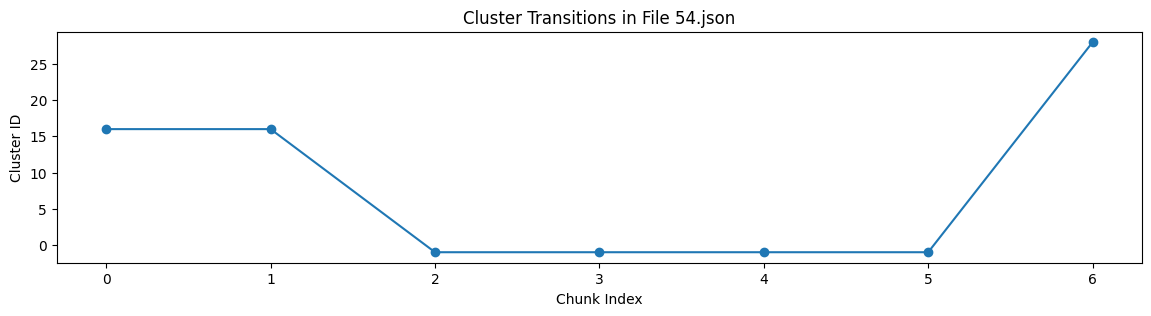

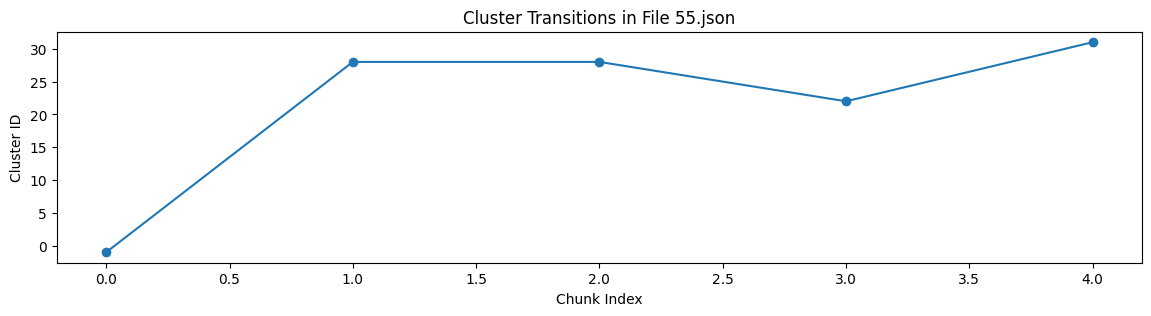

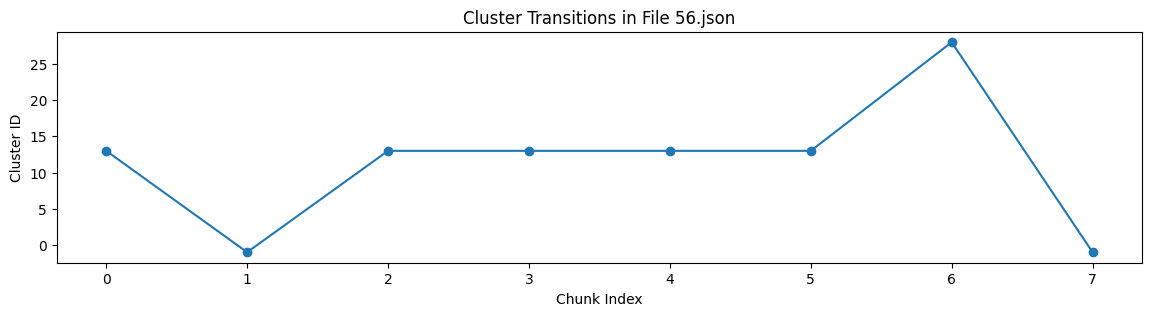

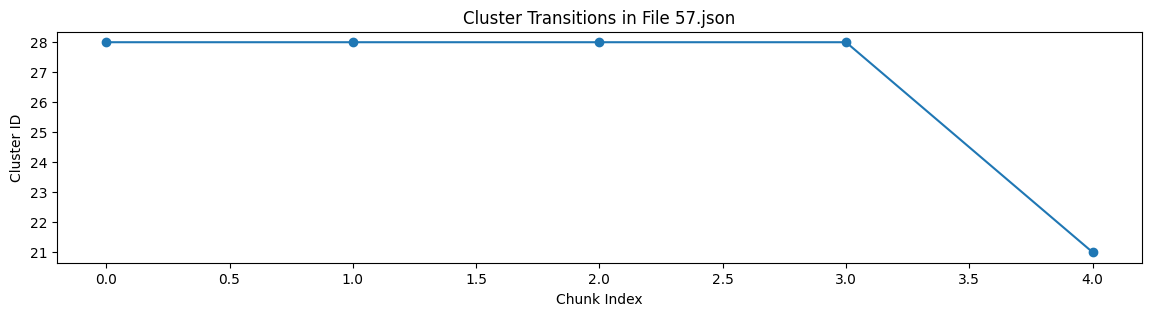

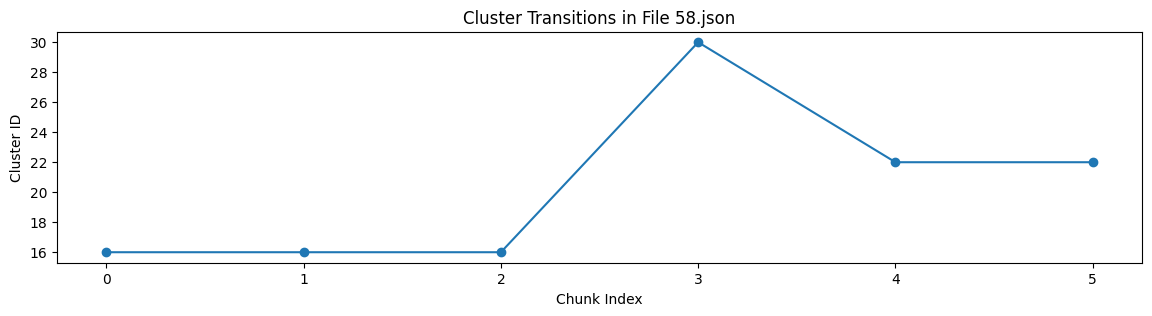

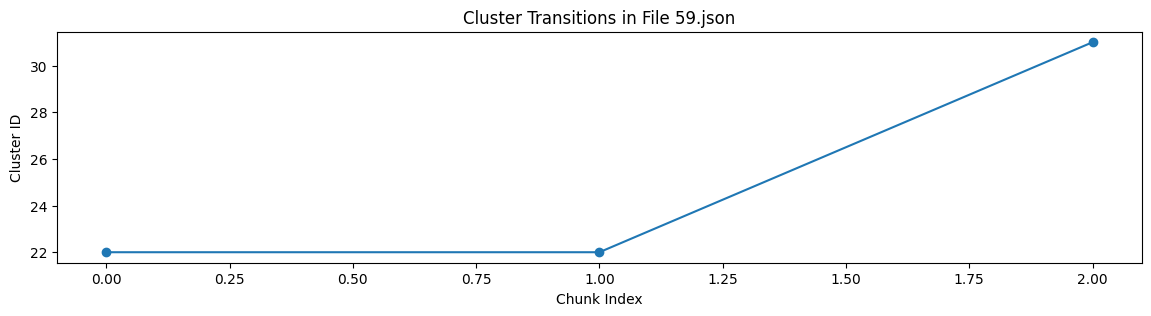

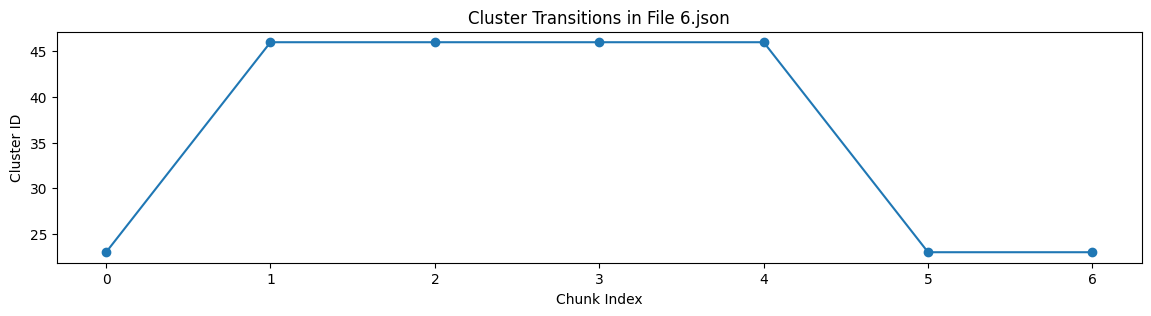

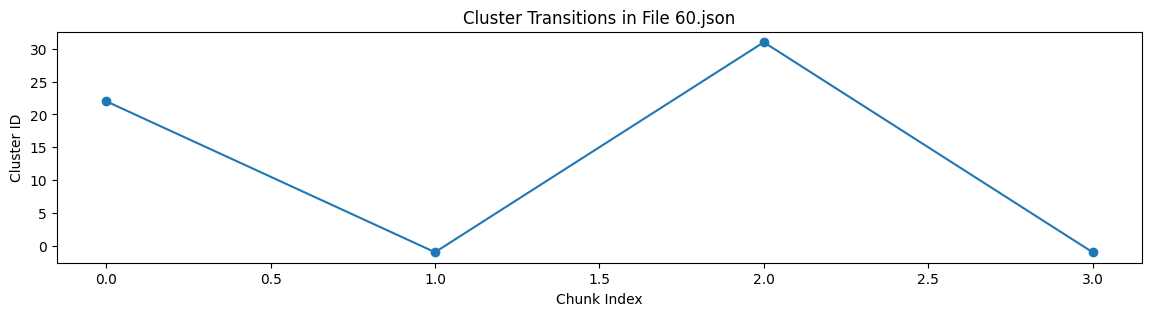

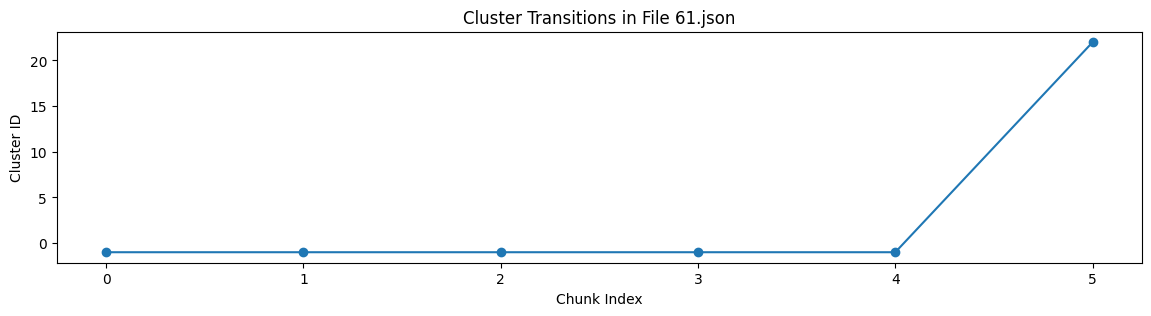

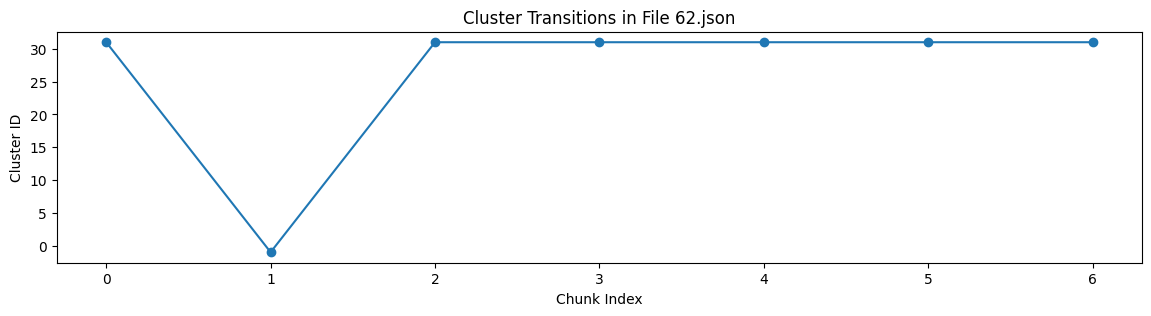

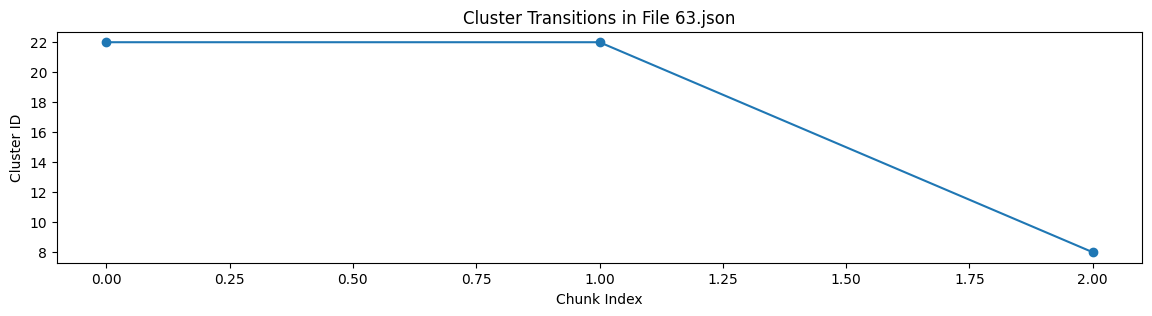

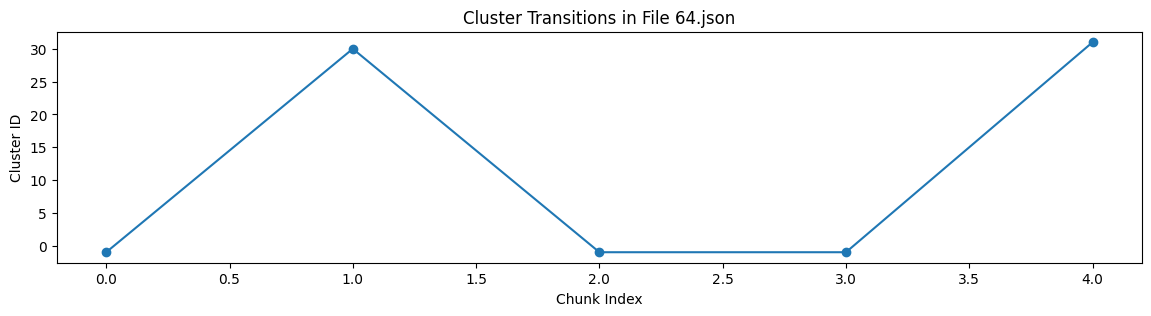

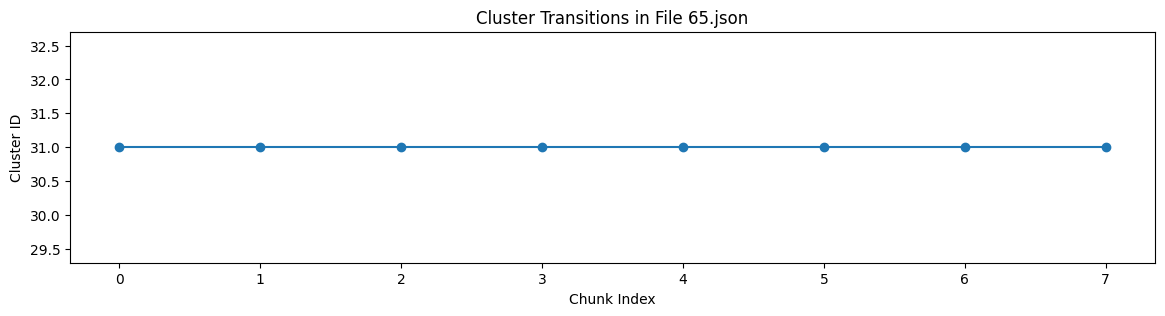

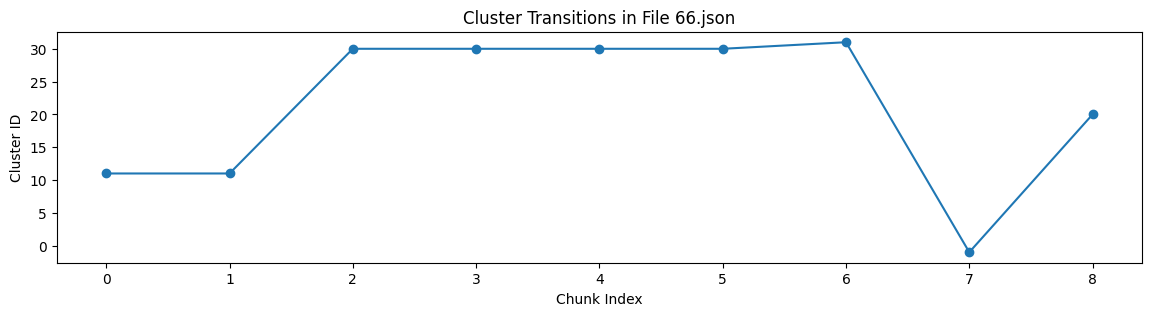

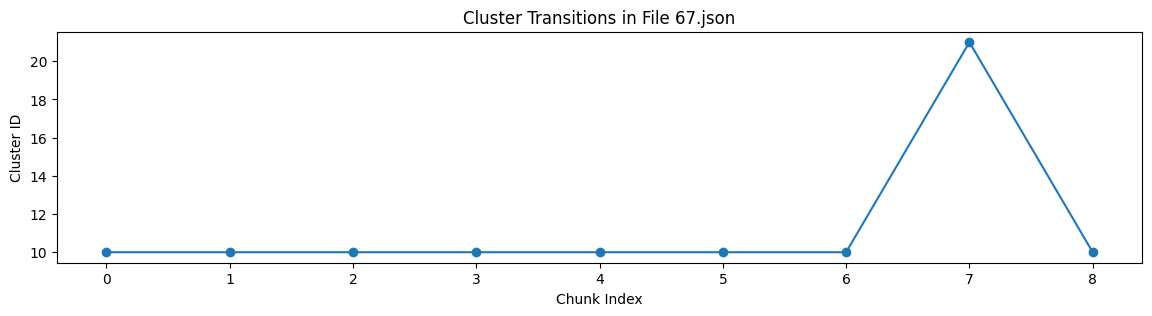

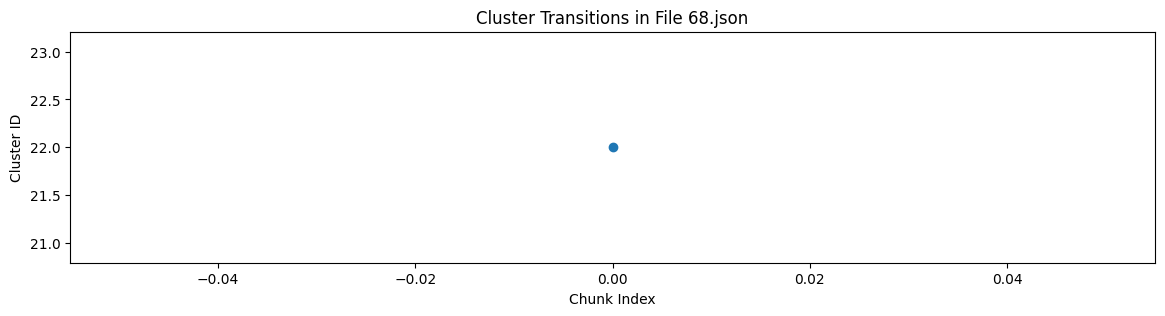

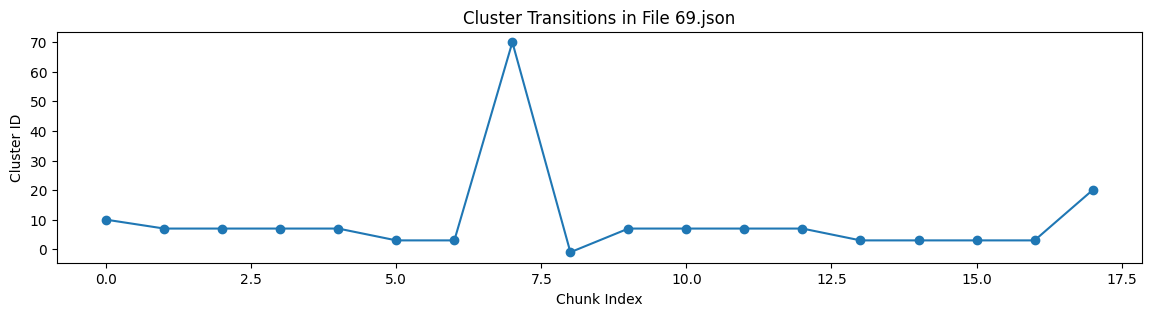

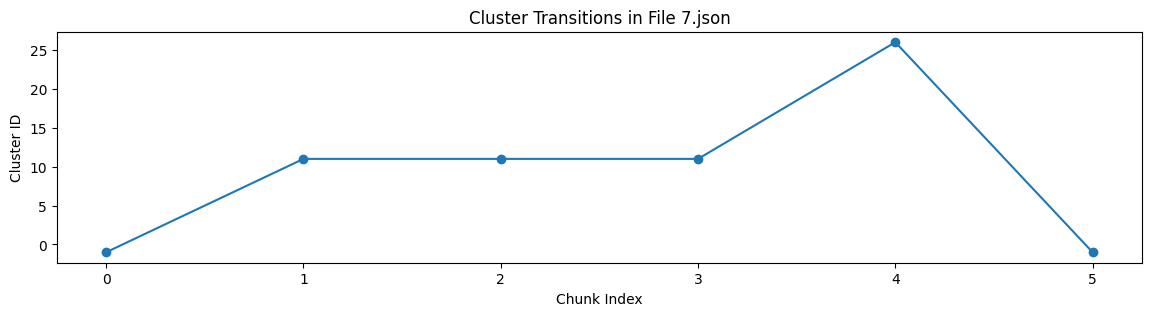

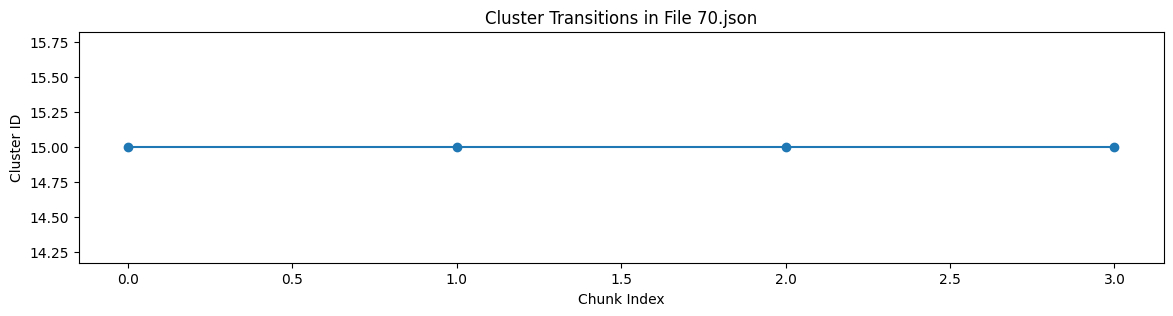

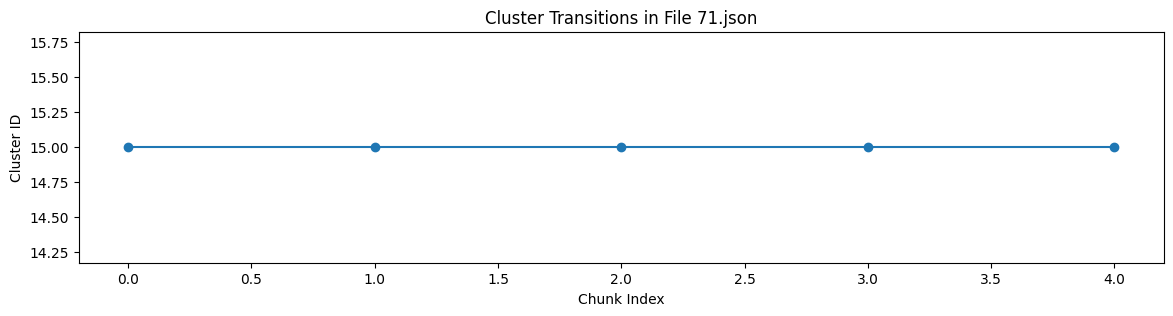

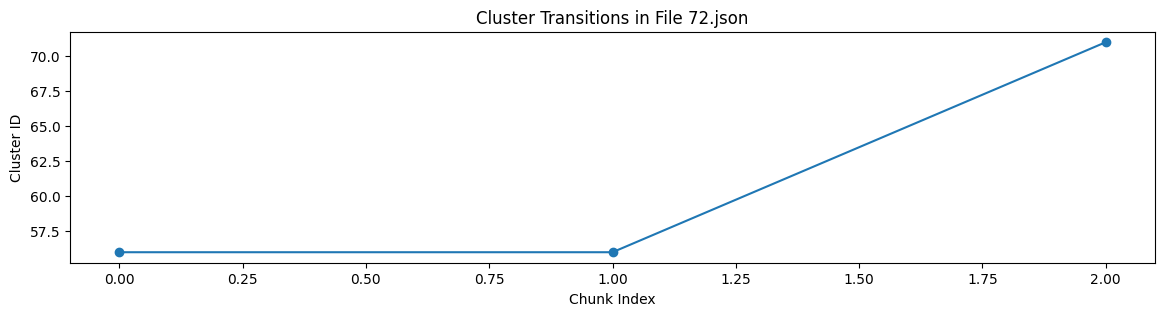

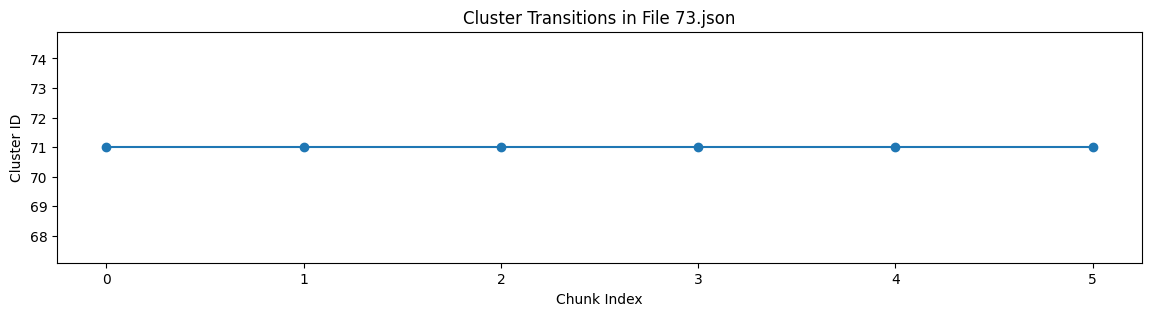

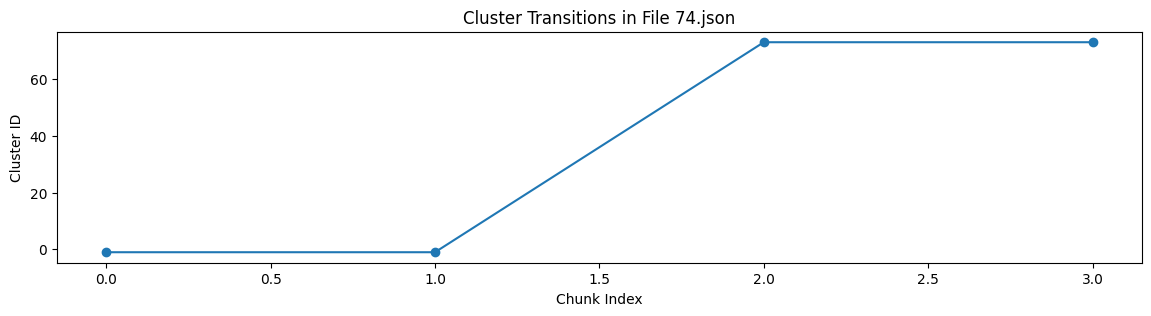

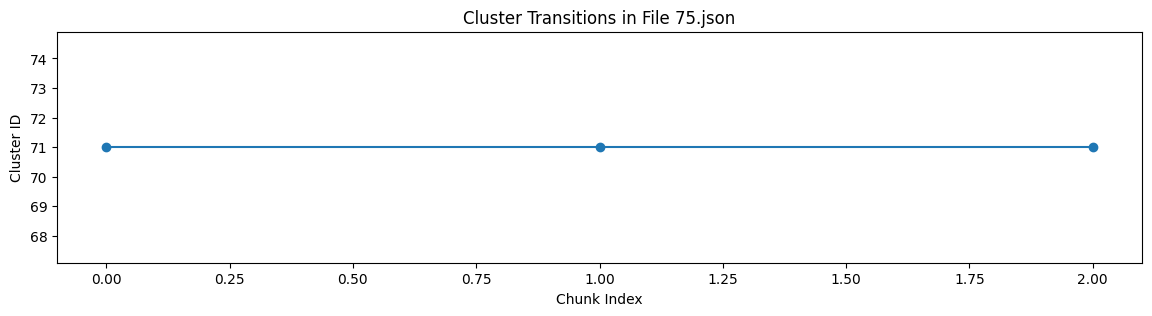

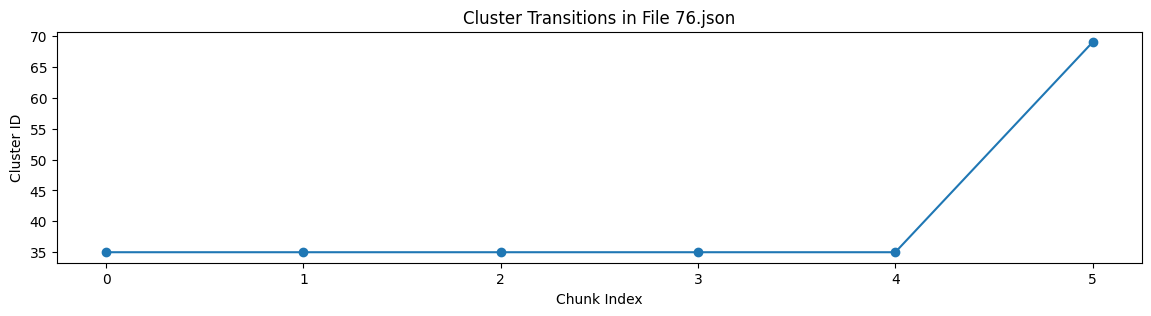

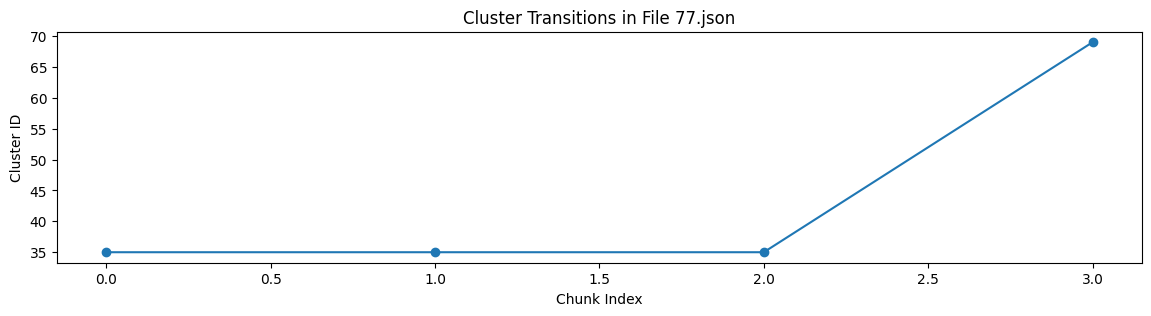

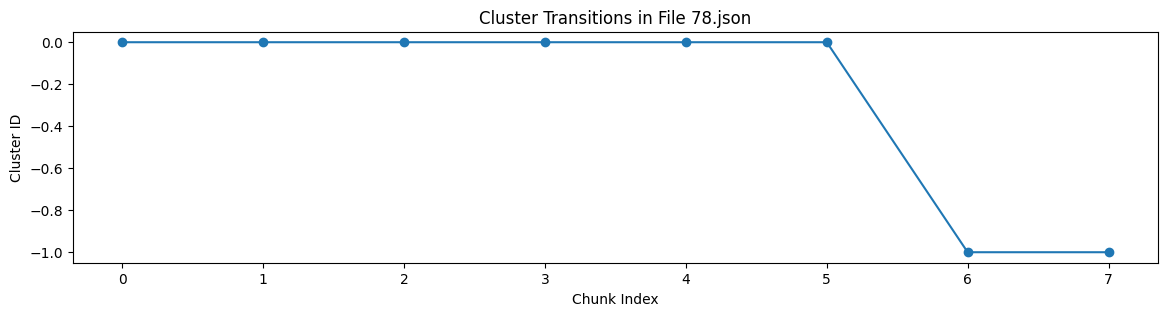

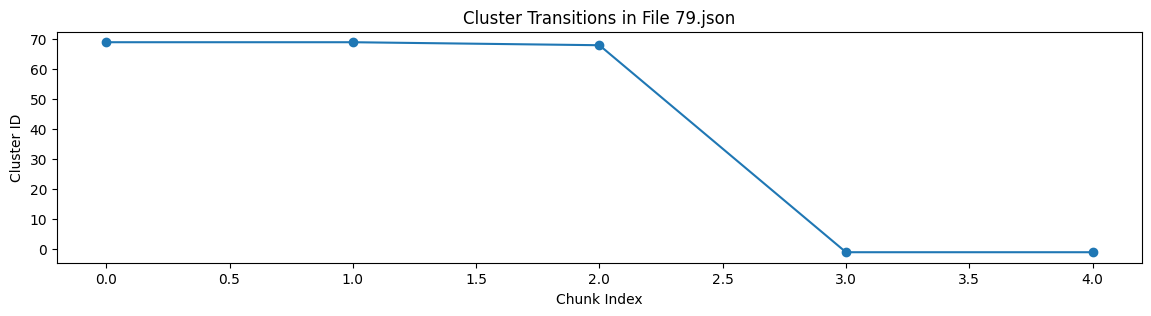

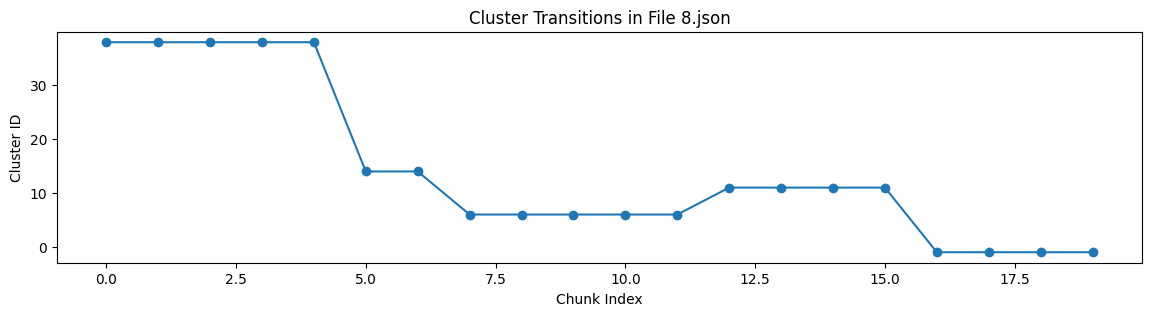

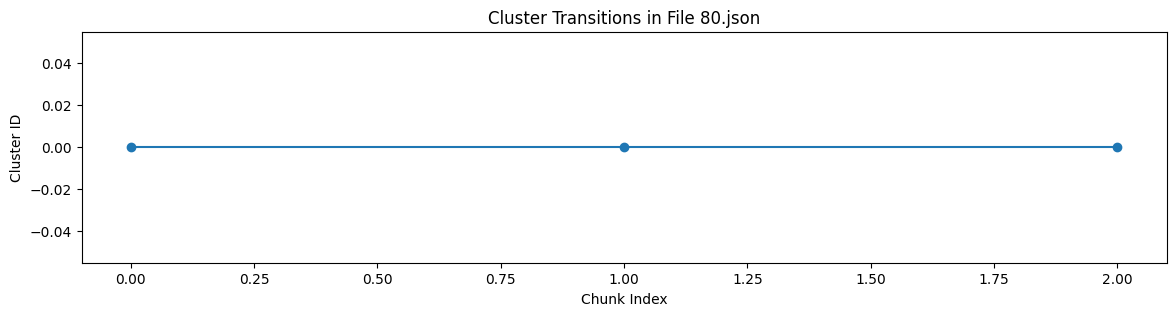

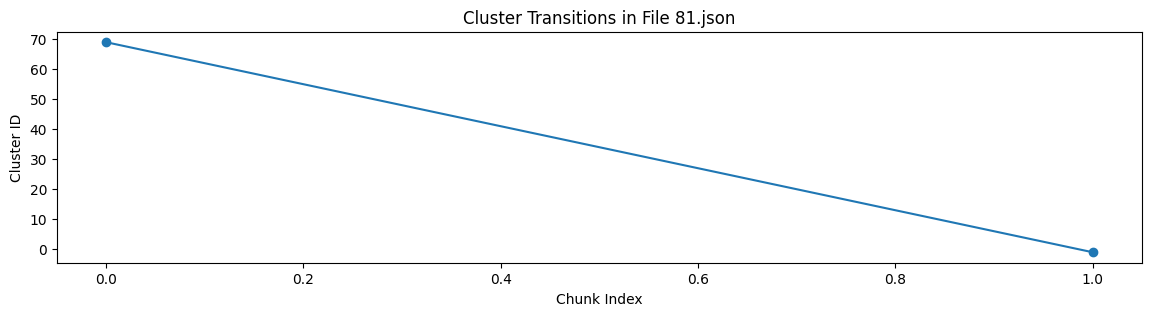

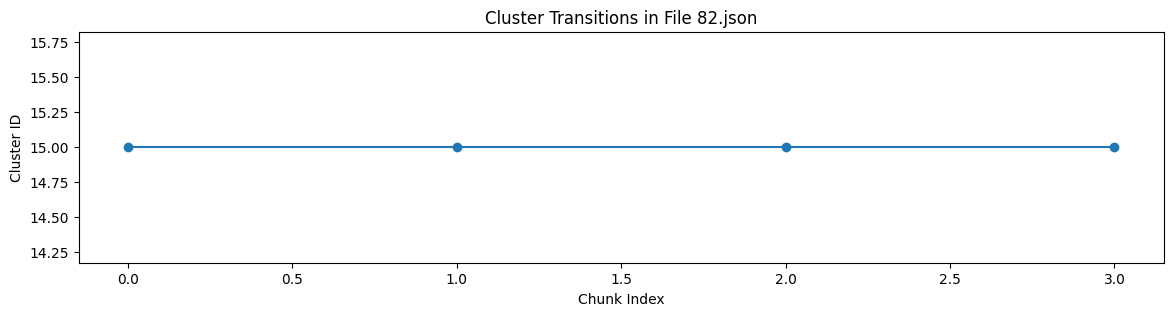

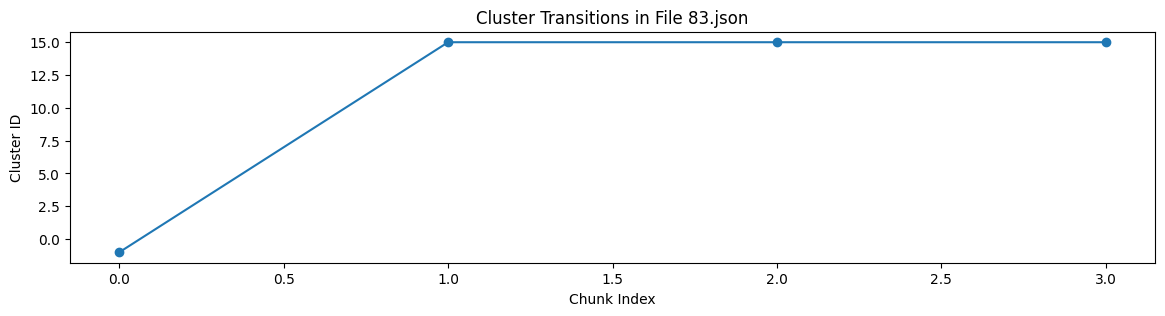

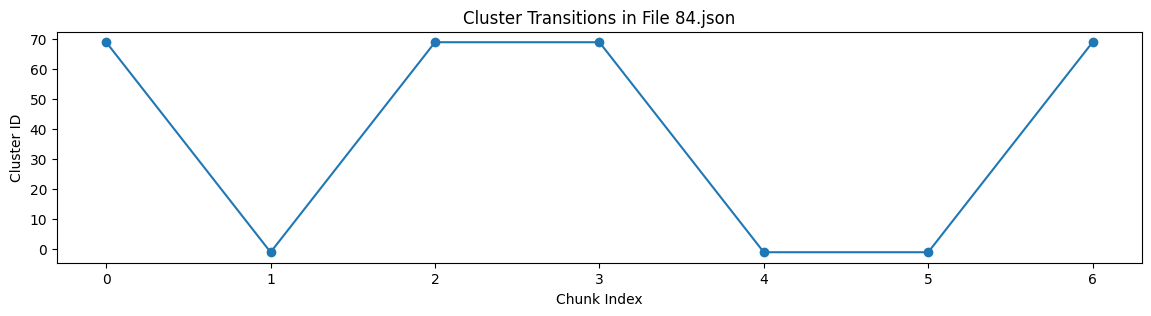

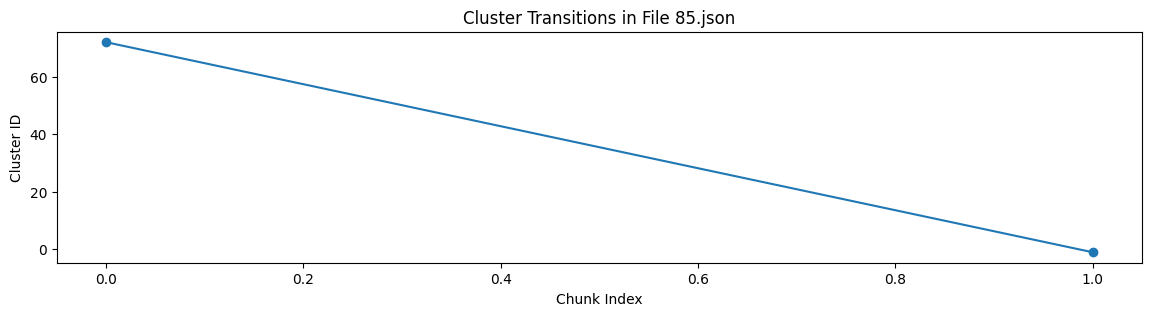

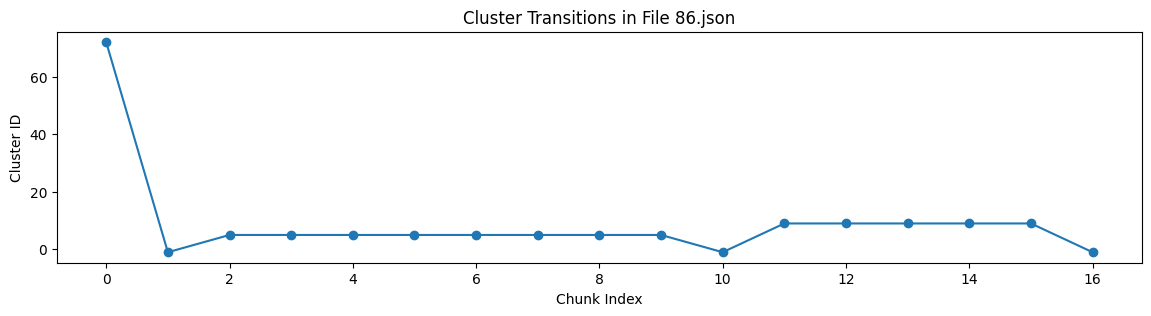

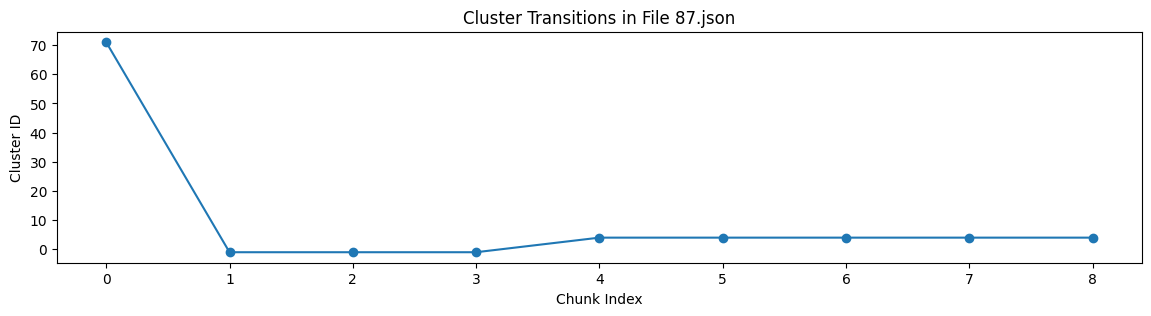

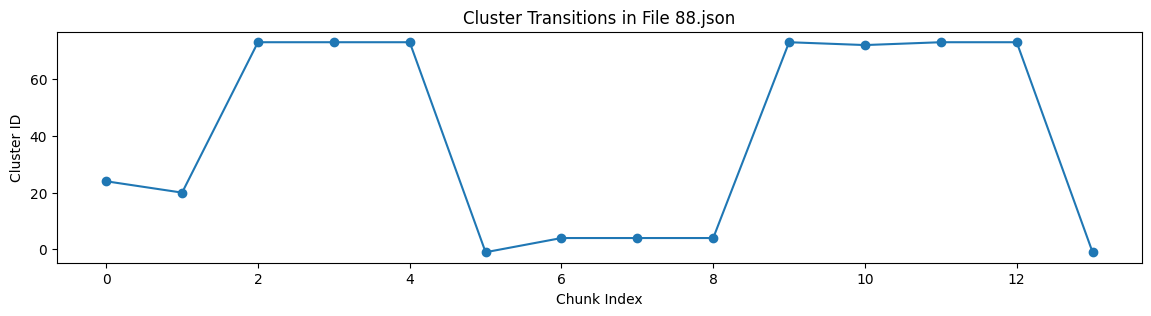

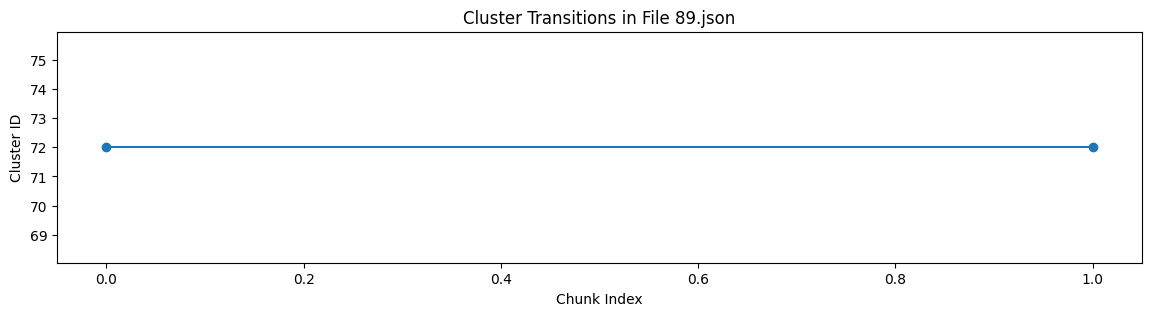

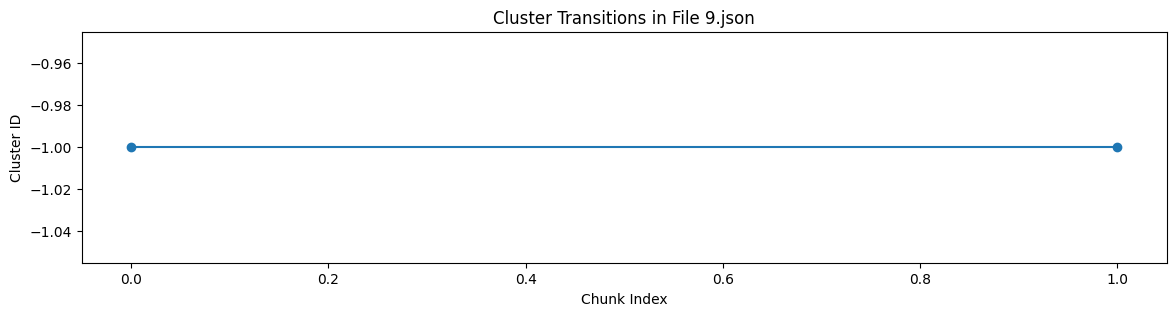

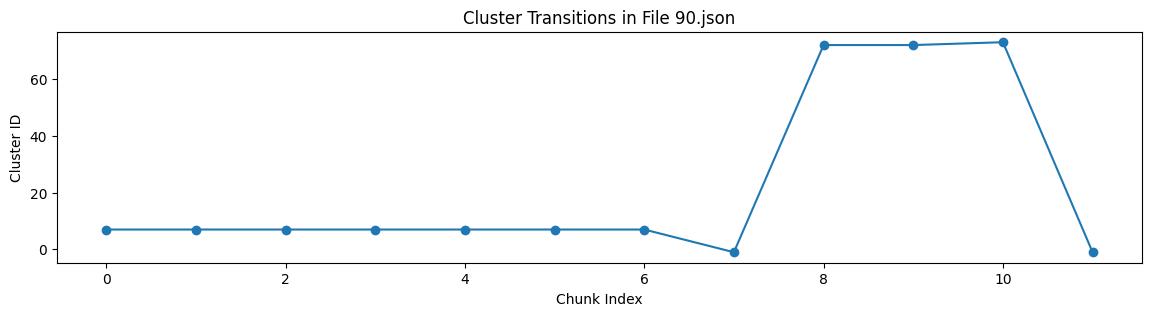

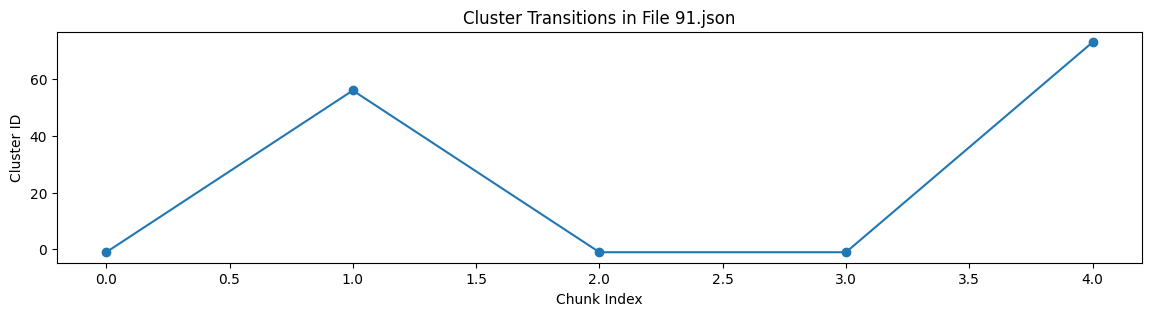

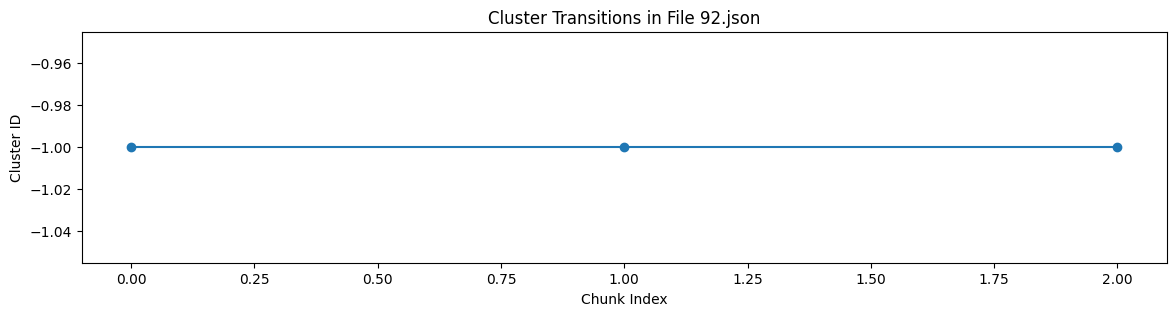

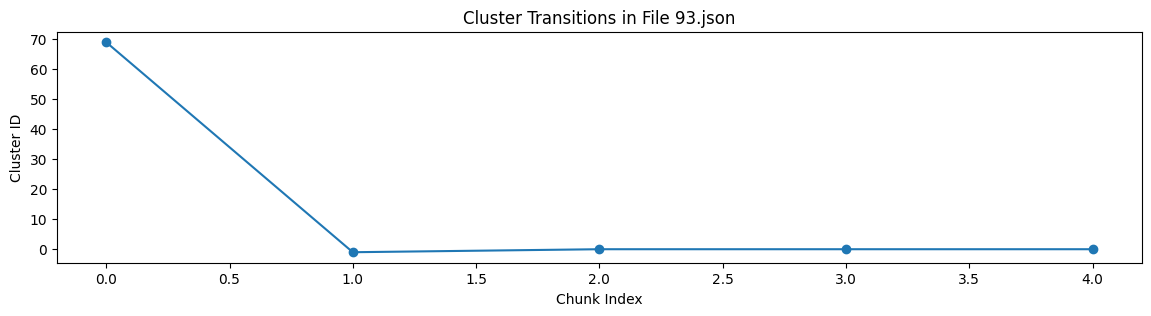

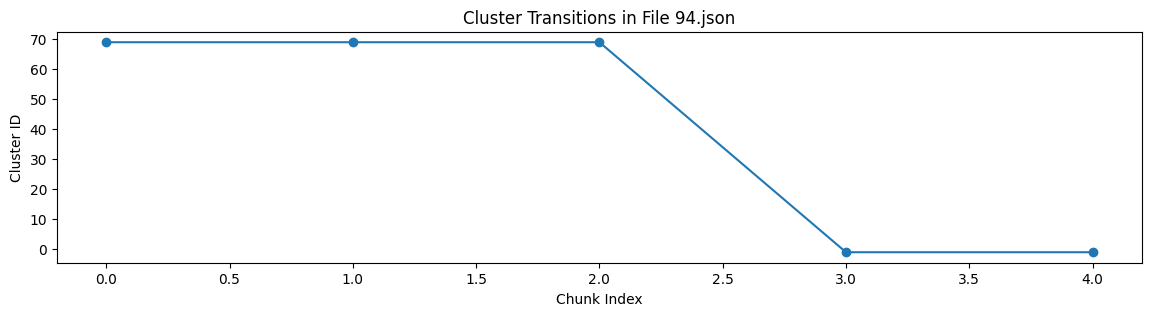

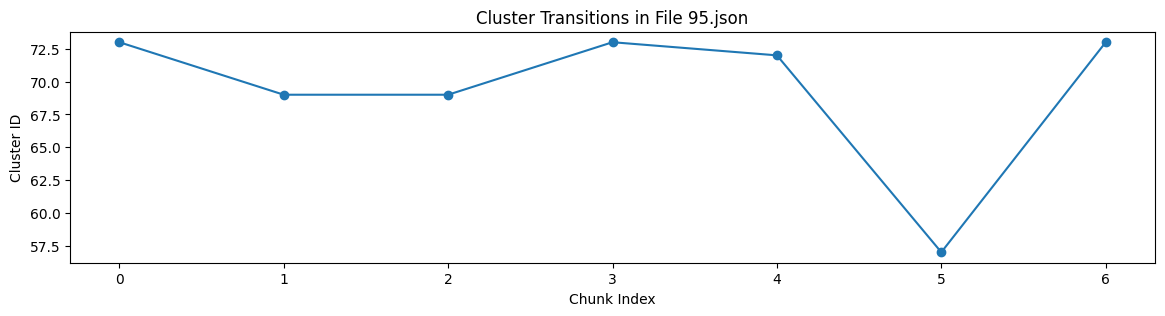

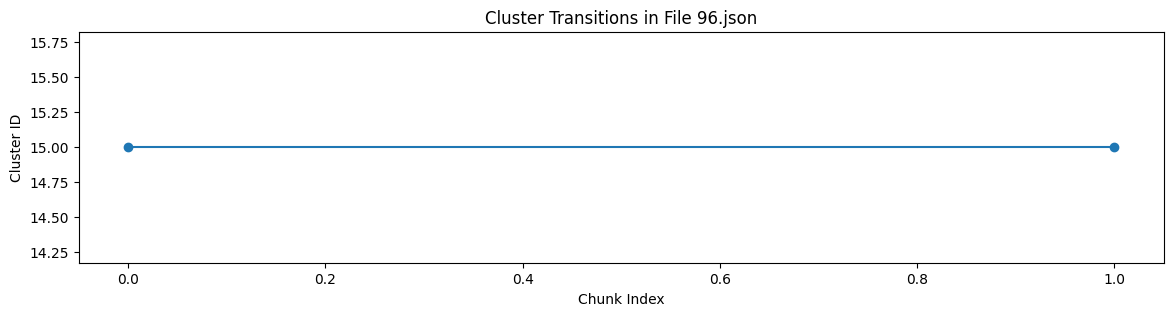

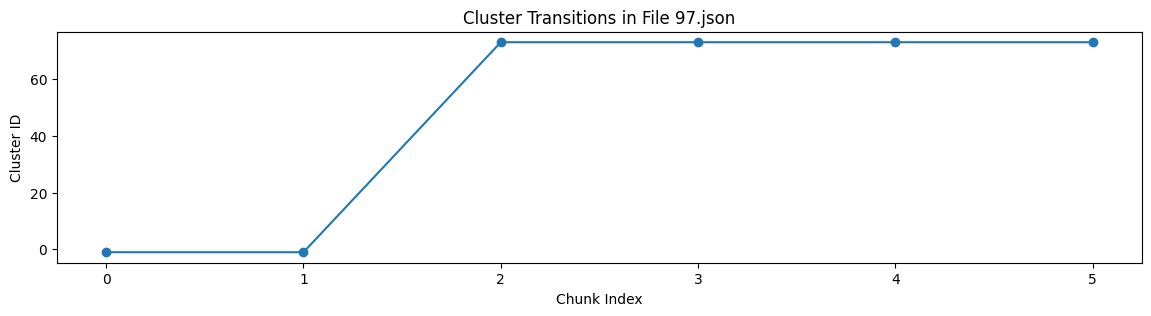

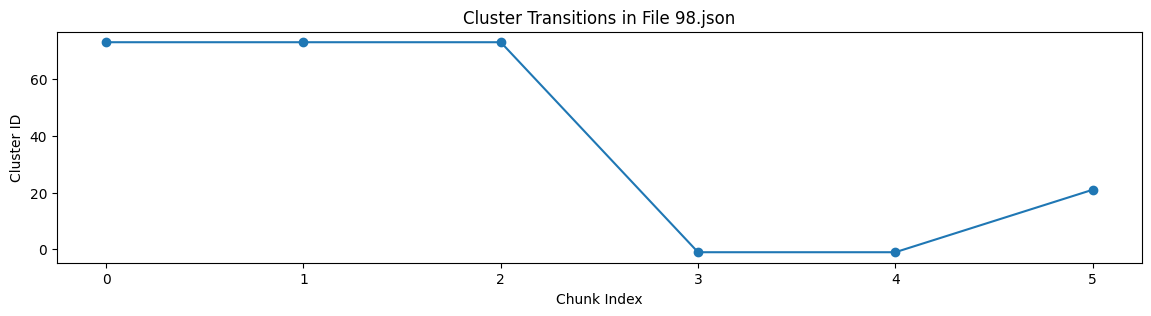

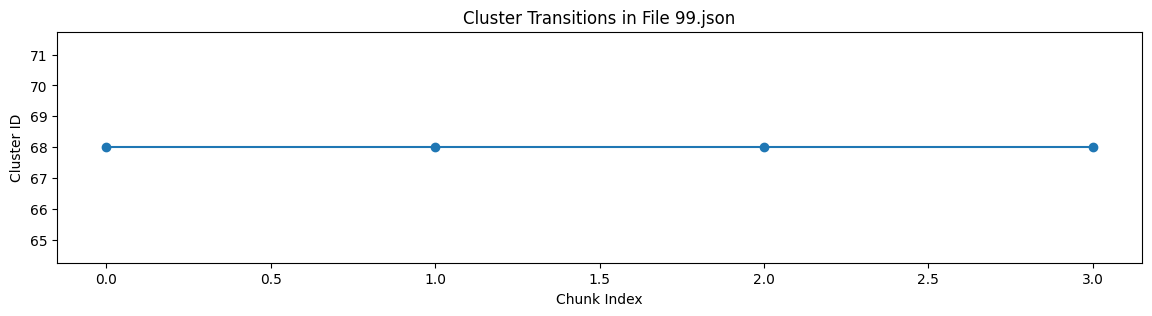

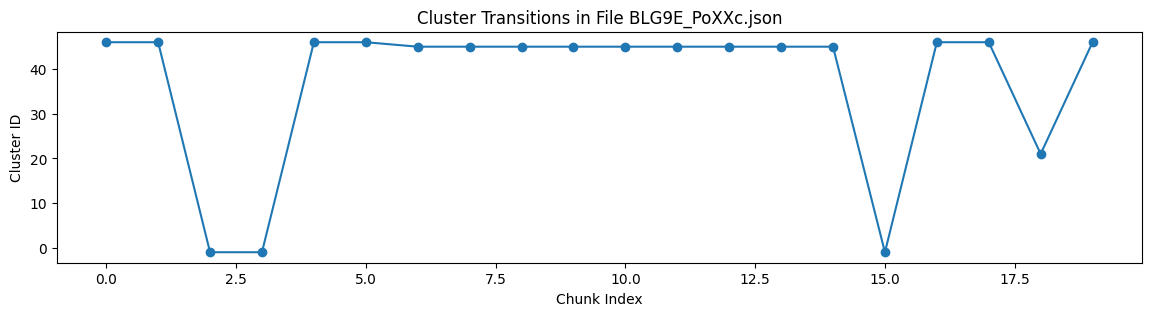

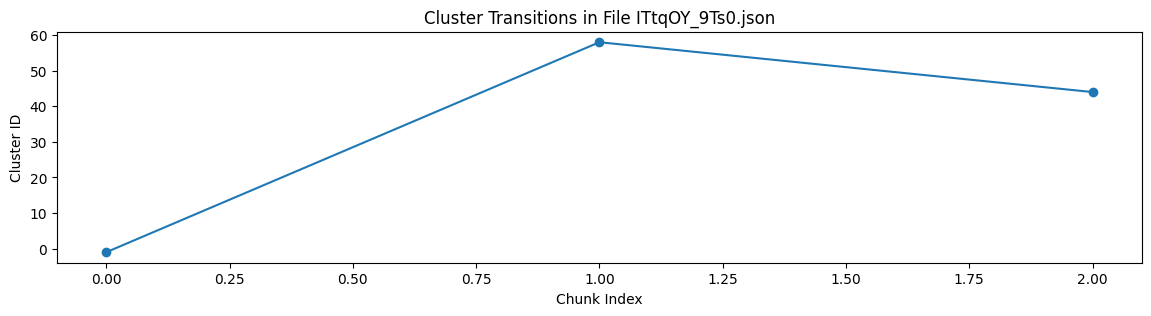

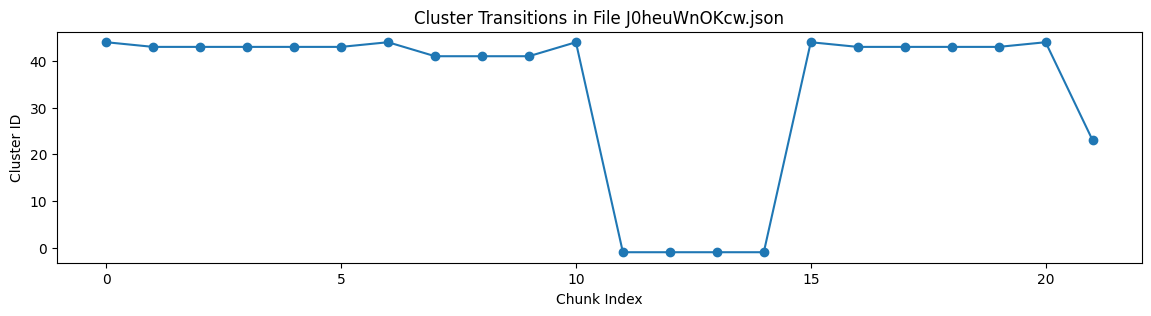

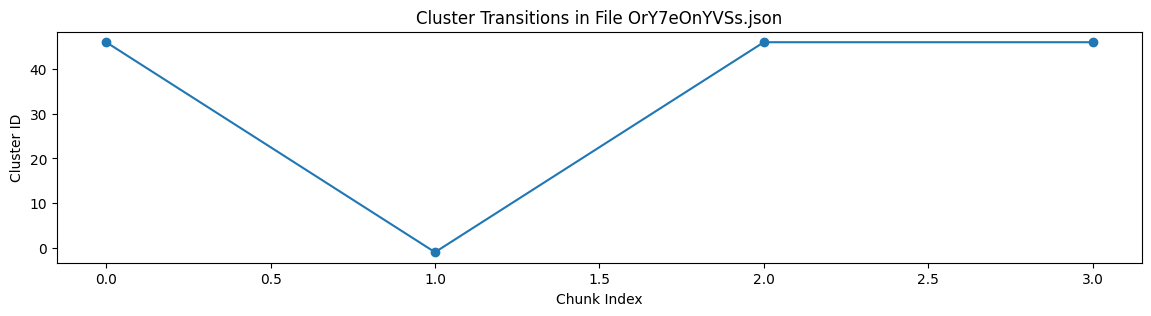

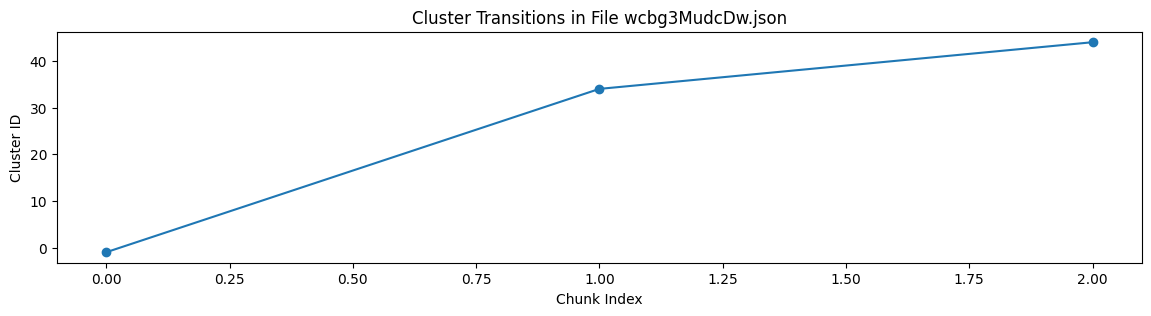

In [6]:
file_ids = df["file"].unique()
for file_id in file_ids:
    video_df = df[df["file"] == file_id]
    plt.figure(figsize=(14, 3))
    plt.plot(video_df["cluster"].values, marker="o", linestyle="-")
    plt.title(f"Cluster Transitions in File {file_id}")
    plt.xlabel("Chunk Index")
    plt.ylabel("Cluster ID")
    plt.show()

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

def top_words_in_cluster(df, cluster_id, top_n=10):
    text = df[df["cluster"] == cluster_id]["text"]
    vec = TfidfVectorizer(stop_words="english", max_features=1000)
    tfidf = vec.fit_transform(text)
    scores = tfidf.sum(axis=0).A1
    indices = scores.argsort()[::-1][:top_n]
    return [vec.get_feature_names_out()[i] for i in indices]

top_words_in_cluster(df, 18)


['laws',
 'understand',
 'let',
 'line',
 'law',
 'supposed',
 'state',
 'lectures',
 'coming',
 'action']